In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
import uproot
uproot.default_library = "np"

In [7]:
import os.path

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

In [9]:
np.set_printoptions(precision=4, suppress=True)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [11]:
raw_names = [
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    #"data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    #"data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    #"DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",

    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
    #"DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [12]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [13]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['e_minus_TRUECosTheta',
 'e_minus_TRUEENDVERTEX_X',
 'e_minus_TRUEENDVERTEX_Y',
 'e_minus_TRUEENDVERTEX_Z',
 'e_minus_TRUEID',
 'e_minus_TRUEISSTABLE',
 'e_minus_TRUEORIGINVERTEX_X',
 'e_minus_TRUEORIGINVERTEX_Y',
 'e_minus_TRUEORIGINVERTEX_Z',
 'e_minus_TRUEPT',
 'e_minus_TRUEP_E',
 'e_minus_TRUEP_X',
 'e_minus_TRUEP_Y',
 'e_minus_TRUEP_Z',
 'e_minus_TRUETAU',
 'e_plus_TRUECosTheta',
 'e_plus_TRUEENDVERTEX_X',
 'e_plus_TRUEENDVERTEX_Y',
 'e_plus_TRUEENDVERTEX_Z',
 'e_plus_TRUEID',
 'e_plus_TRUEISSTABLE',
 'e_plus_TRUEORIGINVERTEX_X',
 'e_plus_TRUEORIGINVERTEX_Y',
 'e_plus_TRUEORIGINVERTEX_Z',
 'e_plus_TRUEPT',
 'e_plus_TRUEP_E',
 'e_plus_TRUEP_X',
 'e_plus_TRUEP_Y',
 'e_plus_TRUEP_Z',
 'e_plus_TRUETAU']

### Truthing

In [14]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [15]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}

In [16]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]

In [17]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [18]:
selectors = [
    Kee_selector,
    #Kmumu_selector,
    Je_selector,
    #Jmu_selector,
    psi2Se_selector,
    #psi2Smu_selector,
    Dphipi_ee_selector,
    #Dphipi_mumu_selector,
]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 6)&(q2_GeV < 12.96))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 9.82)&(q2_GeV < 16.4))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(D_plus_TRUEID)==411)&(abs(Phi_TRUEID)==333)&(abs(Pi_TRUEID)==211))']

In [19]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log


In [20]:
df_index = [
    r"B⁺→K⁺ee",
    #r"B⁺→K⁺µµ",
    r"B⁺→K⁺J/ψ(→ee)",
    #r"B⁺→K⁺J/ψ(→µµ)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    #r"B⁺→K⁺ψ(2S)(→µµ)",
    r"D⁺→π⁺φ(→ee)",
    #r"D⁺→π⁺φ(→µµ)",
]
df = pd.DataFrame(index=df_index)

In [21]:
df["Total"] = [f["e_minus_TRUEID"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b[features[0]].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee           413741   36689  0.088676
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307
D⁺→π⁺φ(→ee)       499520  149292  0.298871

### KS tests

In [22]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

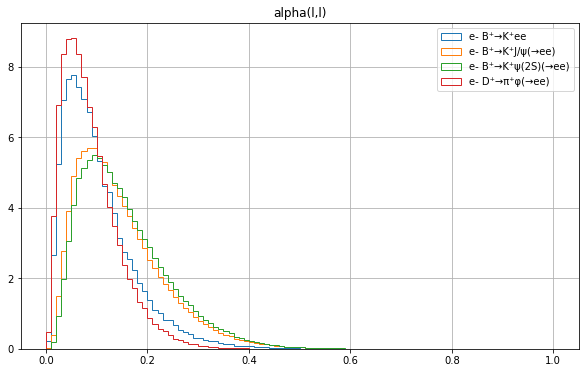

In [23]:
for idx in range(4):
    plt.hist(truthed[idx]['alpha'], label="e- %s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

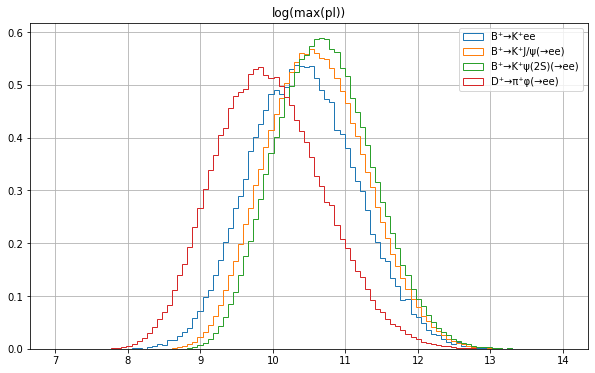

In [24]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(7, 14, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

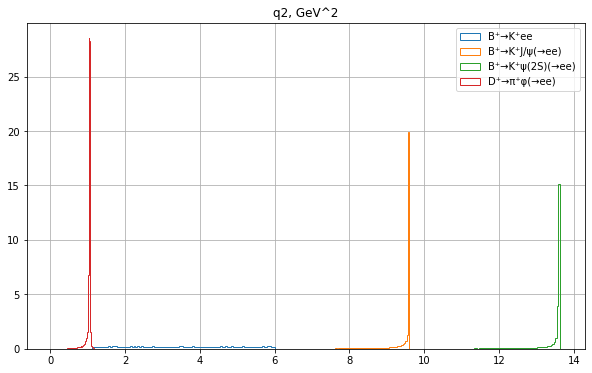

In [25]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2']*1e-6, label="%s"%df_index[idx],
             density=True, bins=100, histtype='step')
plt.title(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

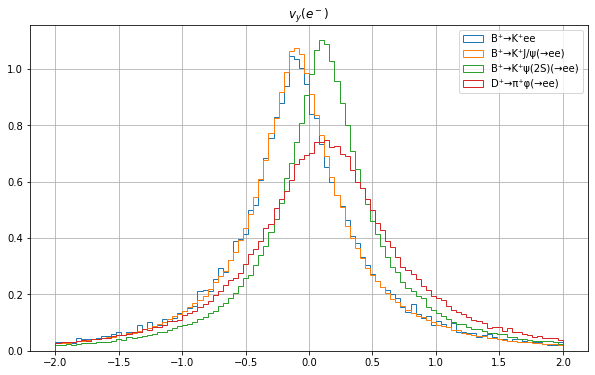

In [26]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['e_plus_TRUEORIGINVERTEX_Y'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^-)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [27]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [28]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [29]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [30]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    #plt.gca().set_aspect('equal')
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [32]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [33]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        total_count = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0]
            total_loss += loss
            total_count += count
            if not accumulate:
                loss /= count
                opt.zero_grad()
                loss.backward()
                opt.step()
        total_loss /= total_count
        if accumulate:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, total_loss)
    model.eval()

### Weight limits estimation

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

In [34]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [35]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [36]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [37]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=10000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [38]:
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.394760
INFO:root:Epoch 1, 1.334515
INFO:root:Epoch 2, 1.318025
INFO:root:Epoch 3, 1.317109
INFO:root:Epoch 4, 1.316555
INFO:root:Epoch 5, 1.316290
INFO:root:Epoch 6, 1.316030
INFO:root:Epoch 7, 1.315920
INFO:root:Epoch 8, 1.315818
INFO:root:Epoch 9, 1.315661
INFO:root:Epoch 10, 1.315611
INFO:root:Epoch 11, 1.315374
INFO:root:Epoch 12, 1.315275
INFO:root:Epoch 13, 1.315173
INFO:root:Epoch 14, 1.315140
INFO:root:Epoch 15, 1.315024
INFO:root:Epoch 16, 1.314858
INFO:root:Epoch 17, 1.314878
INFO:root:Epoch 18, 1.314703
INFO:root:Epoch 19, 1.314680
INFO:root:Epoch 20, 1.314635
INFO:root:Epoch 21, 1.314564
INFO:root:Epoch 22, 1.314529
INFO:root:Epoch 23, 1.314353
INFO:root:Epoch 24, 1.314345
INFO:root:Epoch 25, 1.314325
INFO:root:Epoch 26, 1.314341
INFO:root:Epoch 27, 1.314250
INFO:root:Epoch 28, 1.314193
INFO:root:Epoch 29, 1.314174
INFO:root:Epoch 30, 1.314319
INFO:root:Epoch 31, 1.314013
INFO:root:Epoch 32, 1.314030
INFO:root:Epoch 33, 1.314093
INFO:root:Epoch 34, 1.31

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [39]:
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.373668
INFO:root:Epoch 1, 1.036909
INFO:root:Epoch 2, 0.867689
INFO:root:Epoch 3, 0.829278
INFO:root:Epoch 4, 0.815598
INFO:root:Epoch 5, 0.808624
INFO:root:Epoch 6, 0.803401
INFO:root:Epoch 7, 0.799547
INFO:root:Epoch 8, 0.796212
INFO:root:Epoch 9, 0.793674
INFO:root:Epoch 10, 0.791693
INFO:root:Epoch 11, 0.789925
INFO:root:Epoch 12, 0.788503
INFO:root:Epoch 13, 0.787200
INFO:root:Epoch 14, 0.785818
INFO:root:Epoch 15, 0.784853
INFO:root:Epoch 16, 0.783608
INFO:root:Epoch 17, 0.782637
INFO:root:Epoch 18, 0.781832
INFO:root:Epoch 19, 0.780880
INFO:root:Epoch 20, 0.780372
INFO:root:Epoch 21, 0.779322
INFO:root:Epoch 22, 0.778838
INFO:root:Epoch 23, 0.778266
INFO:root:Epoch 24, 0.777739
INFO:root:Epoch 25, 0.777486
INFO:root:Epoch 26, 0.776801
INFO:root:Epoch 27, 0.776316
INFO:root:Epoch 28, 0.776131
INFO:root:Epoch 29, 0.775902
INFO:root:Epoch 30, 0.775714
INFO:root:Epoch 31, 0.775857
INFO:root:Epoch 32, 0.775389
INFO:root:Epoch 33, 0.775028
INFO:root:Epoch 34, 0.77

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [40]:
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.095065
INFO:root:Epoch 1, 0.971966
INFO:root:Epoch 2, 0.851225
INFO:root:Epoch 3, 0.823913
INFO:root:Epoch 4, 0.818232
INFO:root:Epoch 5, 0.813735
INFO:root:Epoch 6, 0.808528
INFO:root:Epoch 7, 0.803342
INFO:root:Epoch 8, 0.797910
INFO:root:Epoch 9, 0.792615
INFO:root:Epoch 10, 0.787230
INFO:root:Epoch 11, 0.781757
INFO:root:Epoch 12, 0.776726
INFO:root:Epoch 13, 0.772251
INFO:root:Epoch 14, 0.768710
INFO:root:Epoch 15, 0.765901
INFO:root:Epoch 16, 0.763047
INFO:root:Epoch 17, 0.761051
INFO:root:Epoch 18, 0.759469
INFO:root:Epoch 19, 0.757718
INFO:root:Epoch 20, 0.756145
INFO:root:Epoch 21, 0.754752
INFO:root:Epoch 22, 0.753523
INFO:root:Epoch 23, 0.752452
INFO:root:Epoch 24, 0.751298
INFO:root:Epoch 25, 0.750161
INFO:root:Epoch 26, 0.749076
INFO:root:Epoch 27, 0.748128
INFO:root:Epoch 28, 0.747256
INFO:root:Epoch 29, 0.746751
INFO:root:Epoch 30, 0.745809
INFO:root:Epoch 31, 0.745275
INFO:root:Epoch 32, 0.744915
INFO:root:Epoch 33, 0.744649
INFO:root:Epoch 34, 0.74

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

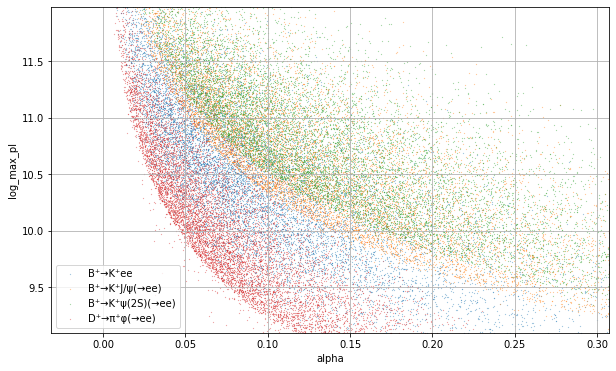

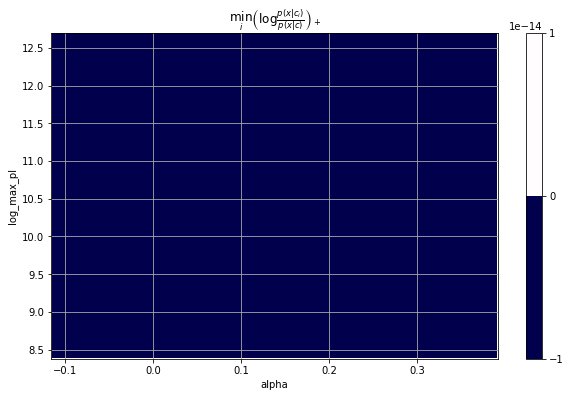

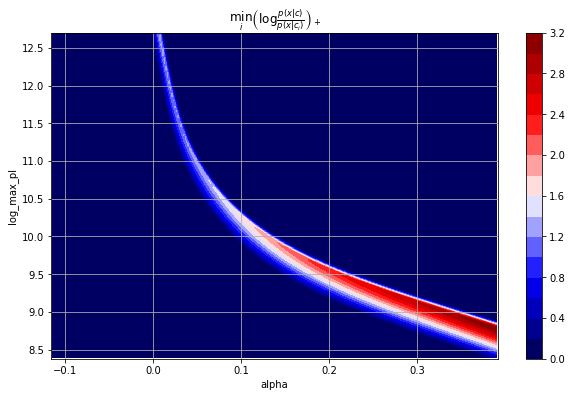

In [41]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

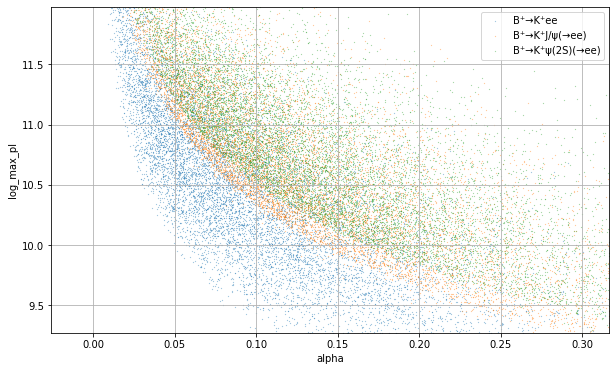

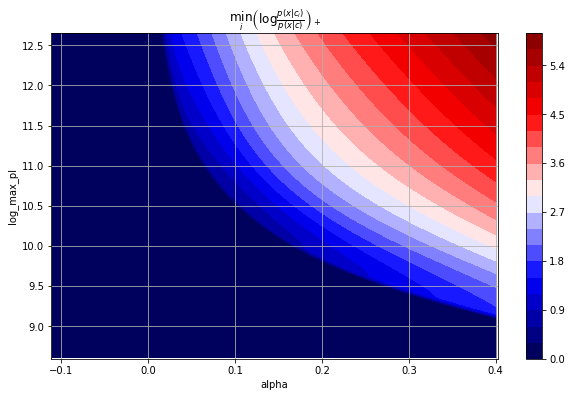

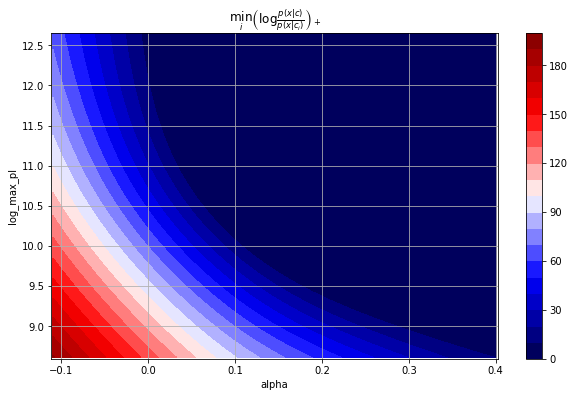

In [42]:
plot_ds(e_la3.ds)
plot_clf_min_max(e_la3.ds, e_la3.model)

In [43]:
e_ptpt = Estimator(["e_minus_TRUEPT", "e_plus_TRUEPT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.430426
INFO:root:Epoch 1, 1.308267
INFO:root:Epoch 2, 1.216475
INFO:root:Epoch 3, 1.193096
INFO:root:Epoch 4, 1.179197
INFO:root:Epoch 5, 1.170775
INFO:root:Epoch 6, 1.165859
INFO:root:Epoch 7, 1.163212
INFO:root:Epoch 8, 1.161745
INFO:root:Epoch 9, 1.160521
INFO:root:Epoch 10, 1.159861
INFO:root:Epoch 11, 1.159442
INFO:root:Epoch 12, 1.159166
INFO:root:Epoch 13, 1.158853
INFO:root:Epoch 14, 1.158768
INFO:root:Epoch 15, 1.158524
INFO:root:Epoch 16, 1.158505
INFO:root:Epoch 17, 1.158283
INFO:root:Epoch 18, 1.158087
INFO:root:Epoch 19, 1.158010
INFO:root:Epoch 20, 1.157812
INFO:root:Epoch 21, 1.157774
INFO:root:Epoch 22, 1.157547
INFO:root:Epoch 23, 1.157278
INFO:root:Epoch 24, 1.157243
INFO:root:Epoch 25, 1.156877
INFO:root:Epoch 26, 1.156949
INFO:root:Epoch 27, 1.156669
INFO:root:Epoch 28, 1.156430
INFO:root:Epoch 29, 1.156062
INFO:root:Epoch 30, 1.155861
INFO:root:Epoch 31, 1.155848
INFO:root:Epoch 32, 1.155173
INFO:root:Epoch 33, 1.154631
INFO:root:Epoch 34, 1.15

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

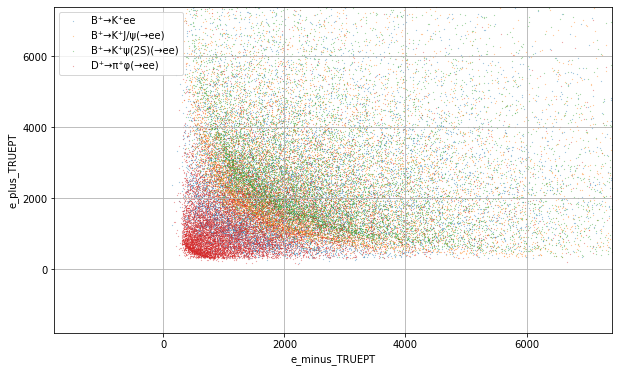

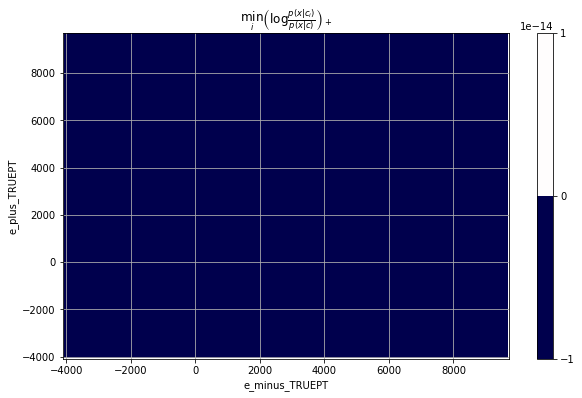

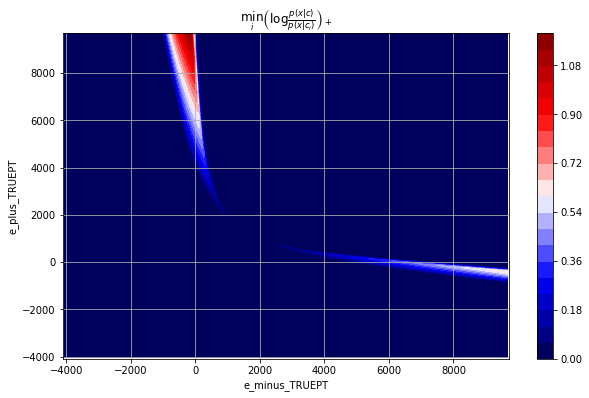

In [44]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [45]:
e_ptpt3 = Estimator(["e_minus_TRUEPT", "e_plus_TRUEPT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.096881
INFO:root:Epoch 1, 1.087775
INFO:root:Epoch 2, 1.074209
INFO:root:Epoch 3, 1.052988
INFO:root:Epoch 4, 1.033821
INFO:root:Epoch 5, 1.024128
INFO:root:Epoch 6, 1.020670
INFO:root:Epoch 7, 1.019417
INFO:root:Epoch 8, 1.019020
INFO:root:Epoch 9, 1.018832
INFO:root:Epoch 10, 1.018631
INFO:root:Epoch 11, 1.018591
INFO:root:Epoch 12, 1.018458
INFO:root:Epoch 13, 1.018086
INFO:root:Epoch 14, 1.018074
INFO:root:Epoch 15, 1.017996
INFO:root:Epoch 16, 1.017845
INFO:root:Epoch 17, 1.017668
INFO:root:Epoch 18, 1.017566
INFO:root:Epoch 19, 1.017380
INFO:root:Epoch 20, 1.017195
INFO:root:Epoch 21, 1.017186
INFO:root:Epoch 22, 1.017013
INFO:root:Epoch 23, 1.016831
INFO:root:Epoch 24, 1.016596
INFO:root:Epoch 25, 1.016313
INFO:root:Epoch 26, 1.016135
INFO:root:Epoch 27, 1.016031
INFO:root:Epoch 28, 1.015788
INFO:root:Epoch 29, 1.015432
INFO:root:Epoch 30, 1.015167
INFO:root:Epoch 31, 1.014816
INFO:root:Epoch 32, 1.014565
INFO:root:Epoch 33, 1.014101
INFO:root:Epoch 34, 1.01

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

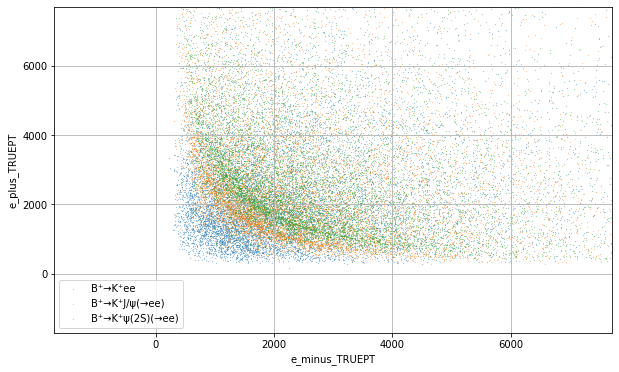

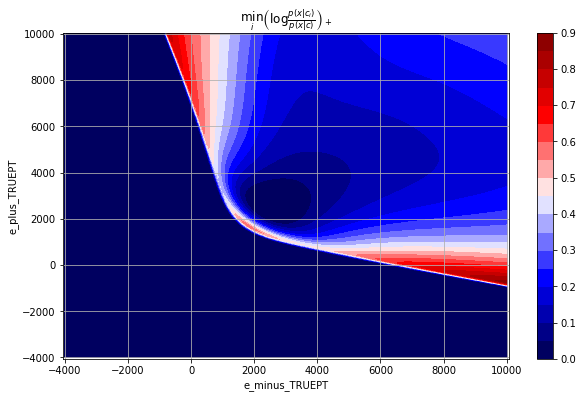

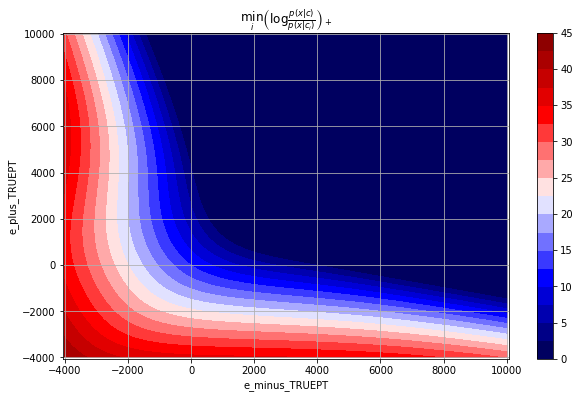

In [46]:
plot_ds(e_ptpt3.ds)
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model)

### Crafting a loss

In [47]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec, 0)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [48]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [49]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [50]:
@torch.no_grad()
def make_weighting(model, loader, selected_class, n_outs, n_classes):
    W = to_numpy(create_w(model, loader, n_outs, n_classes))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [51]:
class Weighting():
    def __init__(self, estimator):
        N = len(list(estimator.ds.indices))
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), N).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
        self.n_outs = N
        self.n_classes = N
    def train(self):
        self.w_model_ = None
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=500, alpha=300)
        return self.w_model()
    def w_model(self):
        if self.w_model_ is None:
            loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
            self.w_model_ = make_weighting(self.model, loader, 0, self.n_outs, self.n_classes)
        return self.w_model_
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [52]:
w_la = Weighting(e_la)
w_la.train()

Epoch 0, loss=-4.000103 est=0.387995 [ 3.6986 -2.5774  1.1244 -1.2208] 0.013206182
Epoch 1, loss=-4.000103 est=0.419989 [ 3.6542 -2.381   0.9405 -1.1955] 0.014571785
Epoch 2, loss=-4.000103 est=0.449538 [ 3.6123 -2.2245  0.8022 -1.1721] 0.015946548
Epoch 3, loss=-4.000103 est=0.481382 [ 3.5604 -2.0774  0.6857 -1.1619] 0.017345866
Epoch 4, loss=-4.000104 est=0.517151 [ 3.5028 -1.9337  0.5839 -1.1615] 0.018774727
Epoch 5, loss=-4.000105 est=0.556718 [ 3.4442 -1.7962  0.4959 -1.1662] 0.020226479
Epoch 6, loss=-4.000106 est=0.599325 [ 3.3883 -1.6685  0.4216 -1.1722] 0.021689916
Epoch 7, loss=-4.000107 est=0.644120 [ 3.3371 -1.5525  0.3599 -1.1764] 0.023154825
Epoch 8, loss=-4.000107 est=0.690556 [ 3.2918 -1.4481  0.3092 -1.1771] 0.024613863
Epoch 9, loss=-4.000107 est=0.738579 [ 3.2525 -1.354   0.2672 -1.1736] 0.026062334
Epoch 10, loss=-4.000107 est=0.788613 [ 3.2186 -1.268   0.2323 -1.1667] 0.02749661
Epoch 11, loss=-4.000107 est=0.841356 [ 3.1889 -1.1886  0.2027 -1.1575] 0.028913371
Epo

Epoch 101, loss=-4.000094 est=1.124473 [ 2.4518 -0.1819  0.0203 -0.8893] 0.064487666
Epoch 102, loss=-4.000094 est=1.125824 [ 2.4508 -0.1814  0.0202 -0.8882] 0.06455318
Epoch 103, loss=-4.000094 est=1.127112 [ 2.4496 -0.1808  0.0202 -0.8872] 0.06461759
Epoch 104, loss=-4.000094 est=1.128351 [ 2.4485 -0.1802  0.0201 -0.8862] 0.06468079
Epoch 105, loss=-4.000094 est=1.129559 [ 2.4474 -0.1797  0.02   -0.8853] 0.064742886
Epoch 106, loss=-4.000094 est=1.130748 [ 2.4462 -0.1792  0.0199 -0.8844] 0.06480391
Epoch 107, loss=-4.000094 est=1.131926 [ 2.4452 -0.1787  0.0199 -0.8834] 0.06486396
Epoch 108, loss=-4.000094 est=1.133096 [ 2.4441 -0.1782  0.0198 -0.8825] 0.06492285
Epoch 109, loss=-4.000093 est=1.134264 [ 2.4431 -0.1777  0.0197 -0.8816] 0.06498083
Epoch 110, loss=-4.000093 est=1.135434 [ 2.4421 -0.1772  0.0197 -0.8807] 0.06503786
Epoch 111, loss=-4.000093 est=1.136601 [ 2.4411 -0.1767  0.0196 -0.8798] 0.065094
Epoch 112, loss=-4.000093 est=1.137748 [ 2.4402 -0.1763  0.0195 -0.8789] 0.0

Epoch 1, loss=-27.297926 est=1.383594 [ 2.5376 -0.1486  0.0171 -0.7228] 0.067545205
Epoch 2, loss=-23.853130 est=1.556259 [ 2.7184 -0.1347  0.0161 -0.6426] 0.0659613
Epoch 3, loss=-20.928253 est=1.727754 [ 2.932  -0.1225  0.015  -0.5788] 0.06348755
Epoch 4, loss=-18.460079 est=1.903516 [ 3.1835 -0.1147  0.0145 -0.5253] 0.06030408
Epoch 5, loss=-16.388372 est=2.081377 [ 3.4769 -0.1104  0.0144 -0.4805] 0.056635577
Epoch 6, loss=-14.653115 est=2.255645 [ 3.8153 -0.1078  0.0145 -0.4433] 0.05270079
Epoch 7, loss=-13.199708 est=2.420124 [ 4.201  -0.1058  0.0146 -0.4132] 0.048687227
Epoch 8, loss=-11.982512 est=2.570018 [ 4.6348 -0.1037  0.0146 -0.3891] 0.044749804
Epoch 9, loss=-10.963867 est=2.703179 [ 5.1149 -0.1015  0.0144 -0.3699] 0.041010514
Epoch 10, loss=-10.111726 est=2.819921 [ 5.6374 -0.099   0.0142 -0.3546] 0.037551288
Epoch 11, loss=-9.398226 est=2.921952 [ 6.1969 -0.0964  0.0138 -0.3422] 0.03441356
Epoch 12, loss=-8.799525 est=3.011372 [ 6.7874 -0.0937  0.0134 -0.3321] 0.0316072

Epoch 99, loss=-7.041526 est=3.366238 [ 9.6761 -0.0721  0.0135 -0.2971] 0.02233313
Epoch 100, loss=-7.029339 est=3.370621 [ 9.7054 -0.072   0.0135 -0.2967] 0.022266801
Epoch 101, loss=-7.017616 est=3.374844 [ 9.7337 -0.0719  0.0135 -0.2963] 0.022203306
Epoch 102, loss=-7.006352 est=3.378937 [ 9.7609 -0.0718  0.0135 -0.296 ] 0.022142591
Epoch 103, loss=-6.995559 est=3.382944 [ 9.7871 -0.0717  0.0135 -0.2956] 0.022084657
Epoch 104, loss=-6.985216 est=3.386897 [ 9.8122 -0.0716  0.0135 -0.2953] 0.022029413
Epoch 105, loss=-6.975331 est=3.390821 [ 9.8362 -0.0716  0.0135 -0.2949] 0.021976754
Epoch 106, loss=-6.965879 est=3.394744 [ 9.8593 -0.0715  0.0135 -0.2946] 0.02192665
Epoch 107, loss=-6.956857 est=3.398672 [ 9.8813 -0.0715  0.0135 -0.2942] 0.021878984
Epoch 108, loss=-6.948256 est=3.402612 [ 9.9024 -0.0714  0.0135 -0.2939] 0.021833688
Epoch 109, loss=-6.940054 est=3.406557 [ 9.9226 -0.0714  0.0135 -0.2936] 0.021790635
Epoch 110, loss=-6.932222 est=3.410501 [ 9.9418 -0.0714  0.0136 -0.2

Epoch 197, loss=-6.350554 est=3.808292 [11.5076 -0.0713  0.0139 -0.2626] 0.01893983
Epoch 198, loss=-6.343577 est=3.814251 [11.5287 -0.0713  0.0139 -0.2622] 0.018907506
Epoch 199, loss=-6.336617 est=3.820238 [11.5498 -0.0713  0.0139 -0.2618] 0.018875265
Epoch 200, loss=-6.329662 est=3.826253 [11.571  -0.0713  0.0139 -0.2614] 0.01884311
Epoch 201, loss=-6.322718 est=3.832301 [11.5921 -0.0713  0.0139 -0.2609] 0.018811077
Epoch 202, loss=-6.315797 est=3.838377 [11.6133 -0.0713  0.0139 -0.2605] 0.018779112
Epoch 203, loss=-6.308876 est=3.844480 [11.6345 -0.0713  0.0139 -0.2601] 0.01874725
Epoch 204, loss=-6.301981 est=3.850613 [11.6557 -0.0713  0.0139 -0.2597] 0.018715486
Epoch 205, loss=-6.295095 est=3.856777 [11.6769 -0.0713  0.0139 -0.2593] 0.018683841
Epoch 206, loss=-6.288219 est=3.862968 [11.6981 -0.0713  0.0139 -0.2589] 0.018652298
Epoch 207, loss=-6.281366 est=3.869191 [11.7194 -0.0713  0.0139 -0.2585] 0.018620841
Epoch 208, loss=-6.274528 est=3.875441 [11.7406 -0.0713  0.0138 -0.2

Epoch 294, loss=-5.780073 est=4.490591 [13.433  -0.0713  0.0132 -0.2227] 0.01643938
Epoch 295, loss=-5.775479 est=4.498290 [13.4502 -0.0713  0.0132 -0.2223] 0.016420491
Epoch 296, loss=-5.770907 est=4.505994 [13.4673 -0.0713  0.0131 -0.2219] 0.016401723
Epoch 297, loss=-5.766364 est=4.513700 [13.4844 -0.0713  0.0131 -0.2215] 0.01638307
Epoch 298, loss=-5.761845 est=4.521397 [13.5014 -0.0713  0.0131 -0.2212] 0.016364528
Epoch 299, loss=-5.757349 est=4.529109 [13.5183 -0.0713  0.0131 -0.2208] 0.016346125
Epoch 300, loss=-5.752880 est=4.536816 [13.5352 -0.0713  0.0131 -0.2204] 0.01632783
Epoch 301, loss=-5.748437 est=4.544524 [13.552  -0.0713  0.0131 -0.22  ] 0.016309641
Epoch 302, loss=-5.744014 est=4.552234 [13.5687 -0.0713  0.0131 -0.2197] 0.01629158
Epoch 303, loss=-5.739616 est=4.559941 [13.5854 -0.0713  0.0131 -0.2193] 0.016273635
Epoch 304, loss=-5.735243 est=4.567649 [13.602  -0.0713  0.0131 -0.2189] 0.016255805
Epoch 305, loss=-5.730895 est=4.575353 [13.6185 -0.0713  0.0131 -0.21

Epoch 392, loss=-5.436646 est=5.193166 [14.7976 -0.0707  0.0118 -0.1926] 0.015057946
Epoch 393, loss=-5.434154 est=5.199491 [14.8086 -0.0707  0.0118 -0.1923] 0.015047659
Epoch 394, loss=-5.431669 est=5.205808 [14.8195 -0.0707  0.0118 -0.1921] 0.0150374295
Epoch 395, loss=-5.429209 est=5.212108 [14.8304 -0.0707  0.0117 -0.1919] 0.015027263
Epoch 396, loss=-5.426764 est=5.218393 [14.8412 -0.0707  0.0117 -0.1916] 0.01501713
Epoch 397, loss=-5.424333 est=5.224666 [14.852  -0.0706  0.0117 -0.1914] 0.015007062
Epoch 398, loss=-5.421921 est=5.230927 [14.8627 -0.0706  0.0117 -0.1912] 0.014997041
Epoch 399, loss=-5.419524 est=5.237177 [14.8734 -0.0706  0.0117 -0.1909] 0.014987068
Epoch 400, loss=-5.417144 est=5.243417 [14.8841 -0.0706  0.0117 -0.1907] 0.014977143
Epoch 401, loss=-5.414781 est=5.249634 [14.8947 -0.0706  0.0117 -0.1905] 0.01496726
Epoch 402, loss=-5.412432 est=5.255841 [14.9053 -0.0706  0.0117 -0.1903] 0.014957432
Epoch 403, loss=-5.410098 est=5.262036 [14.9158 -0.0706  0.0116 -0

Epoch 490, loss=-5.255098 est=5.749364 [15.6868 -0.0703  0.011  -0.1739] 0.014266501
Epoch 491, loss=-5.253745 est=5.754340 [15.6941 -0.0703  0.011  -0.1738] 0.014260404
Epoch 492, loss=-5.252403 est=5.759305 [15.7014 -0.0703  0.011  -0.1736] 0.014254349
Epoch 493, loss=-5.251065 est=5.764243 [15.7086 -0.0703  0.011  -0.1735] 0.014248303
Epoch 494, loss=-5.249740 est=5.769177 [15.7158 -0.0703  0.011  -0.1733] 0.0142423175
Epoch 495, loss=-5.248422 est=5.774095 [15.723  -0.0703  0.011  -0.1732] 0.01423635
Epoch 496, loss=-5.247105 est=5.778998 [15.7302 -0.0703  0.011  -0.173 ] 0.014230404
Epoch 497, loss=-5.245801 est=5.783890 [15.7373 -0.0703  0.011  -0.1729] 0.014224518
Epoch 498, loss=-5.244505 est=5.788761 [15.7444 -0.0703  0.011  -0.1727] 0.014218644
Epoch 499, loss=-5.243209 est=5.793630 [15.7514 -0.0703  0.011  -0.1726] 0.014212801
[[0.0698 0.0012 0.     0.0105]
 [0.2793 0.3709 0.1352 0.0387]
 [0.1759 0.6255 0.8648 0.0025]
 [0.475  0.0024 0.     0.9482]]
|W| =  0.014207004
[[ 15.

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [53]:
w_la3 = Weighting(e_la3)
w_la3.train()

Epoch 0, loss=-3.000091 est=0.830953 [ 1.678  -1.2034  0.5288] 0.04253568
Epoch 1, loss=-3.000085 est=0.937577 [ 1.6901 -1.0666  0.4193] 0.04589684
Epoch 2, loss=-3.000079 est=1.053936 [ 1.7019 -0.9488  0.3305] 0.049277294
Epoch 3, loss=-3.000074 est=1.179146 [ 1.7128 -0.8481  0.2597] 0.052655093
Epoch 4, loss=-3.000071 est=1.312707 [ 1.7226 -0.7618  0.2037] 0.056007523
Epoch 5, loss=-3.000066 est=1.454280 [ 1.7313 -0.6876  0.1595] 0.05931101
Epoch 6, loss=-3.000062 est=1.603555 [ 1.7389 -0.6236  0.1245] 0.06254215
Epoch 7, loss=-3.000059 est=1.760271 [ 1.7455 -0.5681  0.097 ] 0.06567893
Epoch 8, loss=-3.000056 est=1.924245 [ 1.7512 -0.5197  0.0753] 0.06870341
Epoch 9, loss=-3.000053 est=2.095378 [ 1.7563 -0.4772  0.0583] 0.071603216
Epoch 10, loss=-3.000050 est=2.273636 [ 1.7609 -0.4398  0.045 ] 0.07437188
Epoch 11, loss=-3.000047 est=2.459004 [ 1.7652 -0.4067  0.0345] 0.07700822
Epoch 12, loss=-3.000045 est=2.651305 [ 1.7692 -0.3772  0.0264] 0.07951557
Epoch 13, loss=-3.000043 est=2.

Epoch 111, loss=-3.000015 est=9.555670 [ 1.7055 -0.1046  0.0117] 0.1326735
Epoch 112, loss=-3.000015 est=9.577135 [ 1.7052 -0.1044  0.0116] 0.13274035
Epoch 113, loss=-3.000015 est=9.598339 [ 1.7049 -0.1042  0.0116] 0.13280572
Epoch 114, loss=-3.000015 est=9.619100 [ 1.7046 -0.104   0.0115] 0.13286988
Epoch 115, loss=-3.000015 est=9.639517 [ 1.7044 -0.1037  0.0115] 0.13293275
Epoch 116, loss=-3.000015 est=9.659801 [ 1.7041 -0.1035  0.0115] 0.13299452
Epoch 117, loss=-3.000015 est=9.679968 [ 1.7039 -0.1033  0.0114] 0.1330551
Epoch 118, loss=-3.000015 est=9.699835 [ 1.7036 -0.1031  0.0114] 0.13311447
Epoch 119, loss=-3.000015 est=9.719013 [ 1.7034 -0.1029  0.0113] 0.1331729
Epoch 120, loss=-3.000015 est=9.737175 [ 1.7031 -0.1027  0.0113] 0.13323016
Epoch 121, loss=-3.000015 est=9.754237 [ 1.7029 -0.1025  0.0113] 0.13328657
Epoch 122, loss=-3.000015 est=9.770461 [ 1.7026 -0.1023  0.0112] 0.1333418
Epoch 123, loss=-3.000015 est=9.786225 [ 1.7024 -0.1022  0.0112] 0.13339625
Epoch 124, loss=

Epoch 20, loss=-3.048982 est=542.041172 [ 2.7425 -0.0018  0.0001] 0.08435494
Epoch 21, loss=-3.044965 est=590.112483 [ 2.7596 -0.0017  0.0001] 0.084080905
Epoch 22, loss=-3.041877 est=634.313052 [ 2.7729 -0.0016  0.0001] 0.083931744
Epoch 23, loss=-3.039553 est=673.277792 [ 2.7827 -0.0015  0.0001] 0.08389276
Epoch 24, loss=-3.037879 est=705.775638 [ 2.7891 -0.0014  0.0001] 0.08395071
Epoch 25, loss=-3.036761 est=730.958604 [ 2.7924 -0.0014  0.0001] 0.08409361
Epoch 26, loss=-3.036117 est=748.498534 [ 2.7927 -0.0013  0.0001] 0.08431069
Epoch 27, loss=-3.035906 est=758.202359 [ 2.7904 -0.0013  0.0001] 0.0845922
Epoch 28, loss=-3.036062 est=760.659304 [ 2.7856 -0.0013  0.0001] 0.084929585
Epoch 29, loss=-3.036582 est=756.162737 [ 2.7787 -0.0013  0.0001] 0.08531506
Epoch 30, loss=-3.037422 est=745.758010 [ 2.7698 -0.0013  0.0001] 0.08574185
Epoch 31, loss=-3.038551 est=730.494756 [ 2.7591 -0.0014  0.0001] 0.086203836
Epoch 32, loss=-3.039988 est=711.037387 [ 2.747  -0.0014  0.0001] 0.08669

Epoch 126, loss=-3.091411 est=384.496732 [ 2.3413 -0.0026  0.0004] 0.1013406
Epoch 127, loss=-3.091391 est=384.537181 [ 2.3411 -0.0026  0.0004] 0.10136643
Epoch 128, loss=-3.091359 est=384.594340 [ 2.341  -0.0026  0.0004] 0.101392224
Epoch 129, loss=-3.091340 est=384.617140 [ 2.3409 -0.0026  0.0004] 0.10141792
Epoch 130, loss=-3.091334 est=384.611319 [ 2.3407 -0.0026  0.0004] 0.1014432
Epoch 131, loss=-3.091311 est=384.638771 [ 2.3406 -0.0026  0.0004] 0.10146808
Epoch 132, loss=-3.091291 est=384.663712 [ 2.3404 -0.0026  0.0004] 0.101492494
Epoch 133, loss=-3.091258 est=384.718359 [ 2.3403 -0.0026  0.0004] 0.101516366
Epoch 134, loss=-3.091237 est=384.754581 [ 2.3402 -0.0026  0.0004] 0.10153943
Epoch 135, loss=-3.091186 est=384.858804 [ 2.3401 -0.0026  0.0004] 0.10156177
Epoch 136, loss=-3.091152 est=384.936965 [ 2.34   -0.0026  0.0004] 0.10158344
Epoch 137, loss=-3.091103 est=385.055475 [ 2.3399 -0.0026  0.0004] 0.10160427
Epoch 138, loss=-3.091057 est=385.175543 [ 2.3398 -0.0026  0.00

Epoch 231, loss=-3.086416 est=402.272044 [ 2.3363 -0.0025  0.0003] 0.102664866
Epoch 232, loss=-3.086388 est=402.409311 [ 2.3362 -0.0025  0.0003] 0.10267312
Epoch 233, loss=-3.086343 est=402.587801 [ 2.3362 -0.0025  0.0003] 0.10268132
Epoch 234, loss=-3.086309 est=402.738879 [ 2.3361 -0.0025  0.0003] 0.10268957
Epoch 235, loss=-3.086270 est=402.902089 [ 2.3361 -0.0025  0.0003] 0.102697656
Epoch 236, loss=-3.086234 est=403.059493 [ 2.336  -0.0025  0.0003] 0.102705844
Epoch 237, loss=-3.086206 est=403.198813 [ 2.336  -0.0025  0.0003] 0.10271392
Epoch 238, loss=-3.086156 est=403.388763 [ 2.3359 -0.0025  0.0003] 0.1027221
Epoch 239, loss=-3.086143 est=403.490705 [ 2.3358 -0.0025  0.0003] 0.10273025
Epoch 240, loss=-3.086095 est=403.676377 [ 2.3358 -0.0025  0.0003] 0.10273848
Epoch 241, loss=-3.086056 est=403.839095 [ 2.3357 -0.0025  0.0003] 0.10274658
Epoch 242, loss=-3.086006 est=404.029764 [ 2.3357 -0.0025  0.0003] 0.10275472
Epoch 243, loss=-3.086007 est=404.101496 [ 2.3356 -0.0025  0.0

Epoch 337, loss=-3.081123 est=426.950525 [ 2.3262 -0.0023  0.0003] 0.10365648
Epoch 338, loss=-3.081090 est=427.142491 [ 2.3261 -0.0023  0.0003] 0.10366436
Epoch 339, loss=-3.081060 est=427.330421 [ 2.3259 -0.0023  0.0003] 0.10367198
Epoch 340, loss=-3.081020 est=427.550094 [ 2.3258 -0.0023  0.0003] 0.103679426
Epoch 341, loss=-3.080982 est=427.771016 [ 2.3257 -0.0023  0.0003] 0.103686675
Epoch 342, loss=-3.080945 est=427.998052 [ 2.3256 -0.0023  0.0003] 0.10369376
Epoch 343, loss=-3.080907 est=428.228616 [ 2.3255 -0.0023  0.0003] 0.1037008
Epoch 344, loss=-3.080871 est=428.453574 [ 2.3254 -0.0023  0.0003] 0.10370789
Epoch 345, loss=-3.080815 est=428.731701 [ 2.3253 -0.0023  0.0003] 0.10371515
Epoch 346, loss=-3.080805 est=428.881799 [ 2.3251 -0.0023  0.0003] 0.10372269
Epoch 347, loss=-3.080783 est=429.060332 [ 2.325  -0.0023  0.0003] 0.10373043
Epoch 348, loss=-3.080741 est=429.286594 [ 2.3249 -0.0023  0.0003] 0.10373846
Epoch 349, loss=-3.080723 est=429.444595 [ 2.3247 -0.0023  0.00

Epoch 443, loss=-3.076599 est=455.971047 [ 2.3128 -0.0022  0.0003] 0.104446754
Epoch 444, loss=-3.076541 est=456.338758 [ 2.3127 -0.0022  0.0003] 0.10445405
Epoch 445, loss=-3.076489 est=456.687103 [ 2.3126 -0.0022  0.0003] 0.1044613
Epoch 446, loss=-3.076442 est=457.025720 [ 2.3124 -0.0022  0.0003] 0.104468495
Epoch 447, loss=-3.076392 est=457.366397 [ 2.3123 -0.0022  0.0003] 0.10447578
Epoch 448, loss=-3.076340 est=457.715777 [ 2.3122 -0.0022  0.0003] 0.10448307
Epoch 449, loss=-3.076272 est=458.115869 [ 2.3121 -0.0022  0.0003] 0.10449039
Epoch 450, loss=-3.076232 est=458.429303 [ 2.3119 -0.0022  0.0003] 0.10449778
Epoch 451, loss=-3.076169 est=458.816185 [ 2.3118 -0.0022  0.0002] 0.10450502
Epoch 452, loss=-3.076126 est=459.138333 [ 2.3117 -0.0022  0.0002] 0.10451221
Epoch 453, loss=-3.076067 est=459.514122 [ 2.3116 -0.0022  0.0002] 0.10451945
Epoch 454, loss=-3.076012 est=459.878758 [ 2.3114 -0.0022  0.0002] 0.10452671
Epoch 455, loss=-3.075964 est=460.221385 [ 2.3113 -0.0022  0.00

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [54]:
w_ptpt = Weighting(e_ptpt)
w_ptpt.train()

Epoch 0, loss=-4.000042 est=0.074140 [ 24.1508 -13.4881  -2.7608  -6.8664] 0.00043331727
Epoch 1, loss=-4.000044 est=0.082918 [ 22.5685 -12.0601  -2.7439  -6.7397] 0.0005119034
Epoch 2, loss=-4.000047 est=0.092103 [ 21.1191 -10.8575  -2.6383  -6.6516] 0.0005942029
Epoch 3, loss=-4.000051 est=0.101737 [19.8275 -9.8293 -2.5017 -6.5984] 0.00067914784
Epoch 4, loss=-4.000053 est=0.111885 [18.6883 -8.9378 -2.3598 -6.5808] 0.00076566107
Epoch 5, loss=-4.000057 est=0.122577 [17.6831 -8.1581 -2.2212 -6.6003] 0.00085274683
Epoch 6, loss=-4.000059 est=0.133772 [16.7918 -7.4754 -2.0852 -6.6555] 0.0009394979
Epoch 7, loss=-4.000062 est=0.145339 [15.9974 -6.8805 -1.9488 -6.7418] 0.0010251157
Epoch 8, loss=-4.000065 est=0.145937 [15.2861 -6.3667 -1.8095 -6.8523] 0.0011089579
Epoch 9, loss=-4.000069 est=0.143307 [14.6475 -5.9287 -1.6661 -6.978 ] 0.0011906163
Epoch 10, loss=-4.000071 est=0.140670 [14.0732 -5.561  -1.5187 -7.1089] 0.0012699618
Epoch 11, loss=-4.000073 est=0.138233 [13.5572 -5.2582 -1.3

Epoch 97, loss=-4.000130 est=0.174250 [ 7.6803 -2.2582  0.1868 -5.7389] 0.0058242083
Epoch 98, loss=-4.000131 est=0.174595 [ 7.6635 -2.2484  0.1868 -5.7275] 0.005850419
Epoch 99, loss=-4.000131 est=0.174930 [ 7.6466 -2.2388  0.1869 -5.7166] 0.005876347
Epoch 100, loss=-4.000131 est=0.175252 [ 7.6296 -2.2293  0.1869 -5.7061] 0.0059019933
Epoch 101, loss=-4.000131 est=0.175560 [ 7.6127 -2.2199  0.187  -5.696 ] 0.005927373
Epoch 102, loss=-4.000132 est=0.175857 [ 7.5959 -2.2106  0.187  -5.6864] 0.005952491
Epoch 103, loss=-4.000132 est=0.176145 [ 7.5794 -2.2014  0.1869 -5.6772] 0.005977363
Epoch 104, loss=-4.000132 est=0.176426 [ 7.5634 -2.1923  0.1868 -5.6681] 0.00600198
Epoch 105, loss=-4.000133 est=0.176707 [ 7.5481 -2.1834  0.1866 -5.6591] 0.0060263555
Epoch 106, loss=-4.000133 est=0.176991 [ 7.5334 -2.1746  0.1864 -5.65  ] 0.0060504917
Epoch 107, loss=-4.000133 est=0.177283 [ 7.5195 -2.1661  0.1861 -5.6407] 0.006074409
Epoch 108, loss=-4.000133 est=0.177582 [ 7.5063 -2.1579  0.1858 -

Epoch 193, loss=-4.000144 est=0.196225 [ 6.8573 -1.7846  0.1496 -5.0962] 0.007608439
Epoch 194, loss=-4.000144 est=0.196386 [ 6.8528 -1.7823  0.1492 -5.092 ] 0.007621976
Epoch 195, loss=-4.000145 est=0.196547 [ 6.8483 -1.78    0.1488 -5.0879] 0.0076354267
Epoch 196, loss=-4.000145 est=0.196706 [ 6.8439 -1.7777  0.1484 -5.0837] 0.007648787
Epoch 197, loss=-4.000145 est=0.196863 [ 6.8396 -1.7754  0.148  -5.0797] 0.007662071
Epoch 198, loss=-4.000145 est=0.197020 [ 6.8352 -1.7732  0.1476 -5.0756] 0.007675259
Epoch 199, loss=-4.000145 est=0.197176 [ 6.8309 -1.771   0.1472 -5.0716] 0.007688372
Epoch 0, loss=-47.560627 est=0.197331 [ 6.8266 -1.7688  0.1468 -5.0676] 0.0077013946
Epoch 1, loss=-43.332047 est=0.220920 [ 7.4384 -1.8401  0.2001 -4.5265] 0.0075430176
Epoch 2, loss=-39.160595 est=0.240822 [ 8.2054 -1.8712  0.2497 -4.1525] 0.0071547185
Epoch 3, loss=-35.223526 est=0.255418 [ 9.1373 -1.8413  0.2857 -3.9151] 0.006652535
Epoch 4, loss=-31.526707 est=0.264803 [10.2637 -1.761   0.3046 -3

Epoch 89, loss=-17.193005 est=0.276330 [20.196  -1.1881  0.174  -3.6189] 0.0039501633
Epoch 90, loss=-17.163490 est=0.276555 [20.2412 -1.1872  0.175  -3.6159] 0.0039389976
Epoch 91, loss=-17.130932 est=0.276778 [20.2909 -1.1863  0.1759 -3.613 ] 0.003927379
Epoch 92, loss=-17.096659 est=0.276985 [20.3429 -1.1852  0.1767 -3.6103] 0.0039158305
Epoch 93, loss=-17.061958 est=0.277168 [20.3952 -1.1839  0.1773 -3.6079] 0.0039048276
Epoch 94, loss=-17.027973 est=0.277322 [20.4461 -1.1823  0.1777 -3.6059] 0.0038947696
Epoch 95, loss=-16.995695 est=0.277448 [20.4939 -1.1804  0.1779 -3.6043] 0.0038859725
Epoch 96, loss=-16.965923 est=0.277548 [20.5374 -1.1784  0.1779 -3.603 ] 0.0038786642
Epoch 97, loss=-16.939291 est=0.277631 [20.5756 -1.1763  0.1777 -3.6019] 0.0038729908
Epoch 98, loss=-16.916275 est=0.277705 [20.6077 -1.1742  0.1774 -3.6009] 0.0038690395
Epoch 99, loss=-16.897167 est=0.277778 [20.6331 -1.1723  0.1769 -3.6   ] 0.0038668183
Epoch 100, loss=-16.882128 est=0.277856 [20.6518 -1.170

Epoch 184, loss=-16.892183 est=0.287460 [20.2422 -1.0998  0.1594 -3.4787] 0.0040294277
Epoch 185, loss=-16.891041 est=0.287594 [20.2391 -1.0992  0.1594 -3.4771] 0.0040299464
Epoch 186, loss=-16.889845 est=0.287729 [20.2361 -1.0985  0.1593 -3.4755] 0.0040304256
Epoch 187, loss=-16.888573 est=0.287864 [20.2332 -1.0978  0.1593 -3.4739] 0.004030868
Epoch 188, loss=-16.887287 est=0.287999 [20.2304 -1.0972  0.1593 -3.4722] 0.0040312926
Epoch 189, loss=-16.885944 est=0.288135 [20.2276 -1.0965  0.1593 -3.4706] 0.0040316912
Epoch 190, loss=-16.884571 est=0.288272 [20.2248 -1.0959  0.1593 -3.4689] 0.004032077
Epoch 191, loss=-16.883194 est=0.288409 [20.222  -1.0952  0.1593 -3.4673] 0.0040324475
Epoch 192, loss=-16.881783 est=0.288547 [20.2192 -1.0946  0.1593 -3.4656] 0.004032816
Epoch 193, loss=-16.880354 est=0.288685 [20.2164 -1.0939  0.1593 -3.464 ] 0.0040331725
Epoch 194, loss=-16.878941 est=0.288824 [20.2136 -1.0933  0.1593 -3.4623] 0.0040335255
Epoch 195, loss=-16.877493 est=0.288963 [20.21

Epoch 280, loss=-16.363758 est=0.301687 [20.6023 -1.041   0.1648 -3.3147] 0.0039053024
Epoch 281, loss=-16.354866 est=0.301798 [20.6128 -1.0403  0.1647 -3.3135] 0.0039035047
Epoch 282, loss=-16.346149 est=0.301906 [20.623  -1.0395  0.1646 -3.3123] 0.0039018013
Epoch 283, loss=-16.337614 est=0.302013 [20.6331 -1.0387  0.1645 -3.3111] 0.0039001938
Epoch 284, loss=-16.329288 est=0.302117 [20.6428 -1.0379  0.1644 -3.31  ] 0.0038986898
Epoch 285, loss=-16.321188 est=0.302219 [20.6522 -1.0372  0.1642 -3.3089] 0.0038973067
Epoch 286, loss=-16.313309 est=0.302320 [20.6612 -1.0364  0.1641 -3.3078] 0.0038960287
Epoch 287, loss=-16.305687 est=0.302418 [20.6699 -1.0356  0.1639 -3.3067] 0.003894867
Epoch 288, loss=-16.298283 est=0.302515 [20.6783 -1.0348  0.1638 -3.3056] 0.0038938154
Epoch 289, loss=-16.291117 est=0.302610 [20.6863 -1.034   0.1636 -3.3046] 0.0038928743
Epoch 290, loss=-16.284187 est=0.302703 [20.694  -1.0332  0.1634 -3.3036] 0.00389204
Epoch 291, loss=-16.277454 est=0.302794 [20.70

Epoch 375, loss=-15.782930 est=0.308431 [21.256  -0.9531  0.1297 -3.2422] 0.003951516
Epoch 376, loss=-15.775871 est=0.308484 [21.2652 -0.9521  0.1292 -3.2417] 0.003952857
Epoch 377, loss=-15.768766 est=0.308537 [21.2746 -0.951   0.1286 -3.2411] 0.0039541824
Epoch 378, loss=-15.761627 est=0.308589 [21.284  -0.95    0.1281 -3.2406] 0.0039554844
Epoch 379, loss=-15.754453 est=0.308642 [21.2936 -0.949   0.1276 -3.24  ] 0.0039567593
Epoch 380, loss=-15.747232 est=0.308694 [21.3032 -0.9479  0.127  -3.2394] 0.0039580106
Epoch 381, loss=-15.739995 est=0.308746 [21.313  -0.9469  0.1265 -3.2389] 0.0039592423
Epoch 382, loss=-15.732738 est=0.308799 [21.3228 -0.9459  0.126  -3.2384] 0.003960453
Epoch 383, loss=-15.725475 est=0.308851 [21.3327 -0.9448  0.1255 -3.2378] 0.0039616483
Epoch 384, loss=-15.718185 est=0.308902 [21.3426 -0.9438  0.1249 -3.2373] 0.003962821
Epoch 385, loss=-15.710922 est=0.308954 [21.3525 -0.9428  0.1244 -3.2367] 0.003963984
Epoch 386, loss=-15.703653 est=0.309005 [21.3625

Epoch 470, loss=-15.080099 est=0.313576 [22.3446 -0.8708  0.0974 -3.189 ] 0.0039530913
Epoch 471, loss=-15.073809 est=0.313627 [22.3555 -0.8701  0.0972 -3.1885] 0.0039524366
Epoch 472, loss=-15.067525 est=0.313678 [22.3664 -0.8694  0.097  -3.188 ] 0.00395178
Epoch 473, loss=-15.061266 est=0.313729 [22.3773 -0.8688  0.0968 -3.1875] 0.0039511127
Epoch 474, loss=-15.055012 est=0.313780 [22.3882 -0.8681  0.0966 -3.1869] 0.00395044
Epoch 475, loss=-15.048781 est=0.313831 [22.3991 -0.8674  0.0964 -3.1864] 0.003949767
Epoch 476, loss=-15.042562 est=0.313882 [22.4099 -0.8668  0.0963 -3.1859] 0.003949084
Epoch 477, loss=-15.036353 est=0.313932 [22.4208 -0.8661  0.0961 -3.1854] 0.003948391
Epoch 478, loss=-15.030149 est=0.313982 [22.4317 -0.8654  0.0959 -3.1849] 0.0039476957
Epoch 479, loss=-15.023957 est=0.314033 [22.4425 -0.8648  0.0957 -3.1844] 0.0039469916
Epoch 480, loss=-15.017778 est=0.314083 [22.4534 -0.8641  0.0955 -3.1839] 0.003946281
Epoch 481, loss=-15.011597 est=0.314133 [22.4643 -0

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [55]:
w_ptpt3 = Weighting(e_ptpt3)
w_ptpt3.train()

Epoch 0, loss=-3.000054 est=0.203117 [ 5.3536 -4.9233  0.5622] 0.0059215473
Epoch 1, loss=-3.000056 est=0.221816 [ 5.3673 -4.5082  0.3929] 0.0065688607
Epoch 2, loss=-3.000056 est=0.240876 [ 5.3946 -4.1515  0.2515] 0.0071530202
Epoch 3, loss=-3.000055 est=0.260301 [ 5.4345 -3.8417  0.1305] 0.007672013
Epoch 4, loss=-3.000054 est=0.279375 [ 5.4786 -3.5794  0.0328] 0.008129336
Epoch 5, loss=-3.000174 est=0.297148 [ 5.5162 -3.3653 -0.0362] 0.008534414
Epoch 6, loss=-3.000175 est=0.313109 [ 5.541  -3.1938 -0.0775] 0.008899858
Epoch 7, loss=-3.000173 est=0.327117 [ 5.5515 -3.057  -0.0958] 0.0092384685
Epoch 8, loss=-3.000171 est=0.339219 [ 5.5485 -2.9479 -0.097 ] 0.009561779
Epoch 9, loss=-3.000167 est=0.349607 [ 5.5345 -2.8604 -0.0868] 0.009879418
Epoch 10, loss=-3.000160 est=0.358589 [ 5.5131 -2.7887 -0.0709] 0.010198772
Epoch 11, loss=-3.000153 est=0.366543 [ 5.4881 -2.7282 -0.054 ] 0.010525286
Epoch 12, loss=-3.000146 est=0.373856 [ 5.4628 -2.6748 -0.0395] 0.010862631
Epoch 13, loss=-3.

Epoch 109, loss=-3.000036 est=0.884017 [ 4.6877 -1.1312  0.0984] 0.030669726
Epoch 110, loss=-3.000037 est=0.886323 [ 4.684  -1.1283  0.0981] 0.030744191
Epoch 111, loss=-3.000036 est=0.888571 [ 4.6804 -1.1254  0.0978] 0.030817954
Epoch 112, loss=-3.000036 est=0.890787 [ 4.6767 -1.1226  0.0974] 0.030891132
Epoch 113, loss=-3.000036 est=0.892987 [ 4.6732 -1.1198  0.0971] 0.030963669
Epoch 114, loss=-3.000036 est=0.895187 [ 4.6696 -1.1171  0.0968] 0.031035602
Epoch 115, loss=-3.000036 est=0.897401 [ 4.6661 -1.1143  0.0965] 0.031106964
Epoch 116, loss=-3.000036 est=0.899634 [ 4.6627 -1.1116  0.0962] 0.031177768
Epoch 117, loss=-3.000036 est=0.901893 [ 4.6593 -1.1088  0.0959] 0.031248037
Epoch 118, loss=-3.000036 est=0.904178 [ 4.656  -1.106   0.0957] 0.031317793
Epoch 119, loss=-3.000036 est=0.906483 [ 4.6527 -1.1032  0.0954] 0.031387053
Epoch 120, loss=-3.000036 est=0.908798 [ 4.6496 -1.1004  0.0952] 0.031455778
Epoch 121, loss=-3.000036 est=0.911108 [ 4.6464 -1.0976  0.0949] 0.031524092

Epoch 17, loss=-3.291536 est=10.958754 [20.4151 -0.0913  0.0068] 0.0095903985
Epoch 18, loss=-3.273457 est=11.327551 [21.1198 -0.0883  0.0066] 0.009262175
Epoch 19, loss=-3.262087 est=11.585288 [21.598  -0.0863  0.0066] 0.009044612
Epoch 20, loss=-3.256349 est=11.732206 [21.8453 -0.0852  0.0067] 0.008925725
Epoch 21, loss=-3.255482 est=11.773349 [21.8706 -0.0849  0.0069] 0.008895183
Epoch 22, loss=-3.258991 est=11.716981 [21.6939 -0.0853  0.0072] 0.008944072
Epoch 23, loss=-3.266540 est=11.574446 [21.3434 -0.0864  0.0075] 0.009064597
Epoch 24, loss=-3.277943 est=11.358391 [20.8516 -0.088   0.008 ] 0.009249882
Epoch 25, loss=-3.293081 est=11.082829 [20.2526 -0.0902  0.0086] 0.009493681
Epoch 26, loss=-3.311893 est=10.761709 [19.5791 -0.0929  0.0092] 0.009790219
Epoch 27, loss=-3.334334 est=10.408499 [18.8607 -0.0961  0.0099] 0.0101339845
Epoch 28, loss=-3.360344 est=10.035734 [18.1228 -0.0996  0.0106] 0.010519622
Epoch 29, loss=-3.389838 est=9.654333 [17.3862 -0.1036  0.0114] 0.01094173

Epoch 125, loss=-3.821772 est=6.778838 [11.6222 -0.1475  0.0145] 0.016903352
Epoch 126, loss=-3.822109 est=6.779375 [11.6174 -0.1475  0.0145] 0.01691247
Epoch 127, loss=-3.822445 est=6.779877 [11.6128 -0.1475  0.0145] 0.016921563
Epoch 128, loss=-3.822755 est=6.780461 [11.6083 -0.1475  0.0145] 0.016930498
Epoch 129, loss=-3.823034 est=6.781162 [11.604  -0.1475  0.0145] 0.016939137
Epoch 130, loss=-3.823281 est=6.781994 [11.5999 -0.1474  0.0145] 0.016947443
Epoch 131, loss=-3.823482 est=6.783029 [11.5962 -0.1474  0.0145] 0.016955325
Epoch 132, loss=-3.823643 est=6.784249 [11.5928 -0.1474  0.0145] 0.016962744
Epoch 133, loss=-3.823753 est=6.785704 [11.5897 -0.1474  0.0145] 0.016969647
Epoch 134, loss=-3.823817 est=6.787395 [11.5869 -0.1473  0.0145] 0.01697602
Epoch 135, loss=-3.823831 est=6.789331 [11.5845 -0.1473  0.0145] 0.016981889
Epoch 136, loss=-3.823800 est=6.791497 [11.5823 -0.1472  0.0145] 0.016987216
Epoch 137, loss=-3.823722 est=6.793895 [11.5806 -0.1472  0.0145] 0.016992012
E

Epoch 232, loss=-3.801324 est=7.078694 [11.5482 -0.1413  0.014 ] 0.01722632
Epoch 233, loss=-3.800947 est=7.082364 [11.5489 -0.1412  0.014 ] 0.01722701
Epoch 234, loss=-3.800574 est=7.086029 [11.5497 -0.1411  0.0139] 0.017227663
Epoch 235, loss=-3.800194 est=7.089728 [11.5504 -0.141   0.0139] 0.017228292
Epoch 236, loss=-3.799805 est=7.093477 [11.5512 -0.141   0.0139] 0.017228901
Epoch 237, loss=-3.799425 est=7.097192 [11.552  -0.1409  0.0139] 0.017229503
Epoch 238, loss=-3.799037 est=7.100946 [11.5527 -0.1408  0.0139] 0.017230105
Epoch 239, loss=-3.798661 est=7.104640 [11.5535 -0.1408  0.0139] 0.017230732
Epoch 240, loss=-3.798285 est=7.108347 [11.5542 -0.1407  0.0139] 0.01723141
Epoch 241, loss=-3.797914 est=7.112034 [11.5548 -0.1406  0.0139] 0.017232163
Epoch 242, loss=-3.797554 est=7.115667 [11.5554 -0.1405  0.0139] 0.01723302
Epoch 243, loss=-3.797204 est=7.119258 [11.5559 -0.1405  0.0139] 0.017233996
Epoch 244, loss=-3.796868 est=7.122778 [11.5563 -0.1404  0.0139] 0.01723508
Epoc

Epoch 340, loss=-3.773704 est=7.510067 [11.4152 -0.1332  0.0131] 0.017650397
Epoch 341, loss=-3.773700 est=7.513047 [11.412  -0.1331  0.0131] 0.01765759
Epoch 342, loss=-3.773497 est=7.517100 [11.4101 -0.133   0.0131] 0.017662808
Epoch 343, loss=-3.773157 est=7.521900 [11.4092 -0.1329  0.0131] 0.01766659
Epoch 344, loss=-3.772798 est=7.526798 [11.4085 -0.1329  0.0131] 0.01767011
Epoch 345, loss=-3.772531 est=7.531187 [11.4071 -0.1328  0.0131] 0.017674569
Epoch 346, loss=-3.772417 est=7.534731 [11.4047 -0.1327  0.013 ] 0.017680516
Epoch 347, loss=-3.772437 est=7.537553 [11.4015 -0.1327  0.013 ] 0.017687723
Epoch 348, loss=-3.772492 est=7.540166 [11.398  -0.1326  0.013 ] 0.017695257
Epoch 349, loss=-3.772494 est=7.543086 [11.3949 -0.1326  0.013 ] 0.017702127
Epoch 350, loss=-3.772367 est=7.546709 [11.3927 -0.1325  0.013 ] 0.017707726
Epoch 351, loss=-3.772124 est=7.550958 [11.3913 -0.1324  0.013 ] 0.01771213
Epoch 352, loss=-3.771836 est=7.555434 [11.3903 -0.1324  0.013 ] 0.017715998
Epo

Epoch 447, loss=-3.760876 est=7.839729 [11.2511 -0.1276  0.0123] 0.018134879
Epoch 448, loss=-3.760776 est=7.842193 [11.2502 -0.1275  0.0123] 0.018138254
Epoch 449, loss=-3.760674 est=7.844661 [11.2492 -0.1275  0.0123] 0.018141635
Epoch 450, loss=-3.760576 est=7.847097 [11.2482 -0.1274  0.0123] 0.018144993
Epoch 451, loss=-3.760474 est=7.849542 [11.2472 -0.1274  0.0123] 0.018148318
Epoch 452, loss=-3.760378 est=7.851960 [11.2462 -0.1274  0.0123] 0.018151658
Epoch 453, loss=-3.760279 est=7.854380 [11.2453 -0.1273  0.0123] 0.01815495
Epoch 454, loss=-3.760183 est=7.856769 [11.2443 -0.1273  0.0123] 0.018158223
Epoch 455, loss=-3.760080 est=7.859197 [11.2434 -0.1272  0.0123] 0.01816152
Epoch 456, loss=-3.759983 est=7.861580 [11.2424 -0.1272  0.0123] 0.018164763
Epoch 457, loss=-3.759884 est=7.863975 [11.2415 -0.1272  0.0123] 0.018168004
Epoch 458, loss=-3.759784 est=7.866356 [11.2406 -0.1271  0.0123] 0.018171208
Epoch 459, loss=-3.759690 est=7.868706 [11.2397 -0.1271  0.0123] 0.0181744
Epo

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [56]:
w_a4 = Weighting(e_a4)
w_a4.train()
w_a3 = Weighting(e_a3)
w_a3.train()

Epoch 0, loss=-4.000061 est=0.000221 [ 6662.7827 -4529.3047  2225.7249 -4346.401 ] 2.2583226e-09
Epoch 1, loss=-4.000061 est=0.000286 [ 5189.2427 -2640.3489   870.3578 -3491.6921] 4.109539e-09
Epoch 2, loss=-3.999939 est=0.000329 [ 4490.843  -2046.5831   486.2909 -3037.2593] 6.1808274e-09
Epoch 3, loss=-3.999848 est=0.000370 [ 4021.5513 -1785.5099   339.6465 -2704.2913] 8.533739e-09
Epoch 4, loss=-3.999954 est=0.000412 [ 3657.4868 -1654.6941   280.3886 -2429.6165] 1.1211382e-08
Epoch 5, loss=-3.999848 est=0.000457 [ 3351.7866 -1582.2717   257.916  -2189.8765] 1.4265714e-08
Epoch 6, loss=-4.000031 est=0.000505 [ 3089.7498 -1539.8597   251.7881 -1979.1088] 1.7710937e-08
Epoch 7, loss=-4.000000 est=0.000558 [ 2861.4387 -1513.5062   252.9791 -1792.5067] 2.157531e-08
Epoch 8, loss=-3.999985 est=0.000615 [ 2660.4583 -1495.9135   257.1811 -1626.6786] 2.5875183e-08
Epoch 9, loss=-4.000054 est=0.000675 [ 2482.1597 -1482.2754   261.8494 -1479.044 ] 3.063346e-08
Epoch 10, loss=-4.000023 est=0.000

Epoch 86, loss=-3.999992 est=0.002381 [ 522.1039 -419.994   123.3336 -291.9727] 1.1393544e-06
Epoch 87, loss=-4.000015 est=0.002443 [ 515.7756 -409.3342  121.9923 -289.8837] 1.169628e-06
Epoch 88, loss=-4.000015 est=0.002506 [ 509.6382 -398.9969  120.7017 -287.7678] 1.2004274e-06
Epoch 89, loss=-4.000001 est=0.002571 [ 503.6037 -388.8951  119.4293 -285.6109] 1.231934e-06
Epoch 90, loss=-4.000002 est=0.002638 [ 497.7176 -379.0772  118.1917 -283.4537] 1.263966e-06
Epoch 91, loss=-4.000002 est=0.002707 [ 491.9156 -369.4777  116.9623 -281.2954] 1.2967082e-06
Epoch 92, loss=-3.999996 est=0.002777 [ 486.1733 -360.1022  115.7462 -279.1267] 1.3301337e-06
Epoch 93, loss=-3.999990 est=0.002849 [ 480.5626 -351.0107  114.5627 -277.0047] 1.363984e-06
Epoch 94, loss=-4.000007 est=0.002923 [ 475.0392 -342.1561  113.391  -274.9335] 1.3984032e-06
Epoch 95, loss=-4.000004 est=0.002999 [ 469.4844 -333.464   112.2073 -272.8531] 1.4336573e-06
Epoch 96, loss=-3.999994 est=0.003076 [ 464.0471 -325.0492  111.

Epoch 174, loss=-3.999995 est=0.006011 [ 206.7497  -93.3347   50.3831 -166.3669] 5.4231236e-06
Epoch 175, loss=-4.000001 est=0.006044 [ 205.2686  -92.5541   50.0807 -165.4532] 5.47796e-06
Epoch 176, loss=-4.000018 est=0.006077 [ 203.8016  -91.7838   49.7791 -164.542 ] 5.533183e-06
Epoch 177, loss=-3.999999 est=0.006111 [ 202.3657  -91.0327   49.4842 -163.6442] 5.5880932e-06
Epoch 178, loss=-4.000005 est=0.006144 [ 200.9602  -90.3017   49.1971 -162.7578] 5.642685e-06
Epoch 179, loss=-4.000013 est=0.006177 [ 199.5732  -89.5811   48.9117 -161.8823] 5.6974313e-06
Epoch 180, loss=-4.000003 est=0.006210 [ 198.213   -88.8777   48.633  -161.0185] 5.7518914e-06
Epoch 181, loss=-4.000005 est=0.006243 [ 196.8777  -88.1889   48.3594 -160.1686] 5.806122e-06
Epoch 182, loss=-4.000007 est=0.006276 [ 195.5606  -87.5116   48.0895 -159.3264] 5.8603105e-06
Epoch 183, loss=-4.000000 est=0.006309 [ 194.2687  -86.8488   47.825  -158.4971] 5.9142453e-06
Epoch 184, loss=-4.000003 est=0.006342 [ 193.      -86.

Epoch 66, loss=-5.837423 est=0.012621 [163.272  -43.7925  31.7021 -79.2318] 1.0862718e-05
Epoch 67, loss=-5.847744 est=0.012663 [162.3602 -43.5726  31.6497 -78.9727] 1.0921958e-05
Epoch 68, loss=-5.857004 est=0.012706 [161.5513 -43.3548  31.6225 -78.7005] 1.0977129e-05
Epoch 69, loss=-5.865055 est=0.012755 [160.8533 -43.1527  31.6174 -78.3978] 1.1028342e-05
Epoch 70, loss=-5.872148 est=0.012809 [160.2436 -42.9724  31.6266 -78.0729] 1.1076203e-05
Epoch 71, loss=-5.879135 est=0.012863 [159.6478 -42.8045  31.6321 -77.7418] 1.1124156e-05
Epoch 72, loss=-5.886666 est=0.012916 [159.0107 -42.6452  31.6229 -77.4262] 1.1173537e-05
Epoch 73, loss=-5.895277 est=0.012964 [158.288  -42.4882  31.5883 -77.1385] 1.1226736e-05
Epoch 74, loss=-5.904964 est=0.013008 [157.4839 -42.3368  31.5274 -76.8785] 1.12833295e-05
Epoch 75, loss=-5.915409 est=0.013050 [156.6255 -42.1963  31.4444 -76.6262] 1.1342899e-05
Epoch 76, loss=-5.925813 est=0.013094 [155.7782 -42.0774  31.3502 -76.3686] 1.140315e-05
Epoch 77, 

Epoch 157, loss=-6.525528 est=0.015966 [118.7872 -36.8202  27.6744 -62.6327] 1.4738168e-05
Epoch 158, loss=-6.531495 est=0.015992 [118.5071 -36.7893  27.6446 -62.5323] 1.4767911e-05
Epoch 159, loss=-6.537355 est=0.016017 [118.233  -36.7606  27.6163 -62.4324] 1.4796929e-05
Epoch 160, loss=-6.543279 est=0.016043 [117.9581 -36.7316  27.587  -62.3319] 1.4826335e-05
Epoch 161, loss=-6.549097 est=0.016068 [117.6887 -36.7044  27.5587 -62.2339] 1.4855102e-05
Epoch 162, loss=-6.555001 est=0.016094 [117.4168 -36.6761  27.5293 -62.1365] 1.4884268e-05
Epoch 163, loss=-6.560811 est=0.016118 [117.1506 -36.6493  27.5011 -62.0412] 1.4912772e-05
Epoch 164, loss=-6.566552 est=0.016143 [116.8878 -36.6229  27.4735 -61.9459] 1.4940998e-05
Epoch 165, loss=-6.572285 est=0.016168 [116.628  -36.5966  27.4466 -61.8504] 1.4968959e-05
Epoch 166, loss=-6.577925 est=0.016192 [116.3725 -36.5704  27.4201 -61.7582] 1.4996537e-05
Epoch 167, loss=-6.583619 est=0.016216 [116.1164 -36.5434  27.3934 -61.6656] 1.5024217e-05

Epoch 248, loss=-6.940902 est=0.017680 [102.0095 -34.9828  26.0786 -56.5625] 1.6642625e-05
Epoch 249, loss=-6.944223 est=0.017693 [101.8945 -34.9657  26.0693 -56.5211] 1.66569e-05
Epoch 250, loss=-6.947509 est=0.017706 [101.7808 -34.9491  26.0602 -56.4775] 1.6670938e-05
Epoch 251, loss=-6.950704 est=0.017720 [101.6709 -34.9335  26.0518 -56.4345] 1.6684678e-05
Epoch 252, loss=-6.953954 est=0.017733 [101.5589 -34.917   26.0431 -56.393 ] 1.669844e-05
Epoch 253, loss=-6.957154 est=0.017746 [101.4489 -34.9006  26.0344 -56.3512] 1.671212e-05
Epoch 254, loss=-6.960233 est=0.017759 [101.3432 -34.8852  26.0265 -56.3095] 1.6725493e-05
Epoch 255, loss=-6.963430 est=0.017772 [101.2338 -34.8682  26.0179 -56.2692] 1.6738928e-05
Epoch 256, loss=-6.966527 est=0.017785 [101.1282 -34.8522  26.0097 -56.2285] 1.6752352e-05
Epoch 257, loss=-6.969614 est=0.017798 [101.0234 -34.8368  26.0021 -56.1859] 1.6765443e-05
Epoch 258, loss=-6.972689 est=0.017810 [100.9185 -34.8204  25.9938 -56.1471] 1.6778598e-05
Epo

Epoch 340, loss=-7.144189 est=0.018658 [ 95.4142 -33.775   25.6448 -53.5958] 1.7525264e-05
Epoch 341, loss=-7.147651 est=0.018653 [ 95.3091 -33.7388  25.6263 -53.6093] 1.7537353e-05
Epoch 342, loss=-7.156001 est=0.018618 [ 95.0568 -33.6373  25.5665 -53.7115] 1.756315e-05
Epoch 343, loss=-7.145854 est=0.018693 [ 95.3635 -33.7715  25.6541 -53.4965] 1.7536566e-05
Epoch 344, loss=-7.155498 est=0.018649 [ 95.0721 -33.651   25.5825 -53.6226] 1.7566565e-05
Epoch 345, loss=-7.155766 est=0.018662 [ 95.064  -33.6538  25.5887 -53.5834] 1.7569362e-05
Epoch 346, loss=-7.150796 est=0.018708 [ 95.2143 -33.7259  25.6383 -53.4533] 1.7557259e-05
Epoch 347, loss=-7.161498 est=0.018659 [ 94.8916 -33.5969  25.5618 -53.5939] 1.7589571e-05
Epoch 348, loss=-7.155803 est=0.018708 [ 95.0629 -33.6769  25.6164 -53.4517] 1.7575505e-05
Epoch 349, loss=-7.158007 est=0.018709 [ 94.9966 -33.6531  25.6058 -53.4509] 1.7583792e-05
Epoch 350, loss=-7.163960 est=0.018686 [ 94.8179 -33.5803  25.5639 -53.5152] 1.7602844e-05


Epoch 433, loss=-7.211760 est=0.019258 [ 93.4072 -33.1355  25.6083 -51.9257] 1.7872417e-05
Epoch 434, loss=-7.236518 est=0.019113 [ 92.692  -32.8267  25.4044 -52.32  ] 1.794644e-05
Epoch 435, loss=-7.219607 est=0.019227 [ 93.1793 -33.0381  25.5514 -52.0098] 1.7898536e-05
Epoch 436, loss=-7.224972 est=0.019203 [ 93.0241 -32.9754  25.5132 -52.0743] 1.7915478e-05
Epoch 437, loss=-7.234132 est=0.019154 [ 92.7604 -32.8635  25.4408 -52.2096] 1.794307e-05
Epoch 438, loss=-7.217012 est=0.019265 [ 93.2538 -33.073   25.5852 -51.9081] 1.7893906e-05
Epoch 439, loss=-7.236076 est=0.019154 [ 92.7048 -32.8342  25.4276 -52.2078] 1.7951352e-05
Epoch 440, loss=-7.223780 est=0.019236 [ 93.0585 -32.9821  25.5312 -51.9852] 1.7917078e-05
Epoch 441, loss=-7.226437 est=0.019226 [ 92.9818 -32.9476  25.5112 -52.0119] 1.7926064e-05
Epoch 442, loss=-7.234767 est=0.019182 [ 92.7424 -32.8449  25.4448 -52.1336] 1.7951488e-05
Epoch 443, loss=-7.221135 est=0.019273 [ 93.1348 -33.0143  25.5632 -51.8867] 1.7912298e-05
E

Epoch 24, loss=-2.999987 est=0.014956 [ 17.9939 -66.8615  38.4219] 0.00028527572
Epoch 25, loss=-2.999999 est=0.015315 [ 17.7344 -65.2933  37.0935] 0.00029672822
Epoch 26, loss=-3.000010 est=0.015674 [ 17.5036 -63.8018  35.833 ] 0.0003081611
Epoch 27, loss=-3.000003 est=0.016032 [ 17.2981 -62.3744  34.6319] 0.0003195947
Epoch 28, loss=-3.000003 est=0.016389 [ 17.1179 -61.0149  33.4918] 0.00033097496
Epoch 29, loss=-3.000010 est=0.016751 [ 16.9566 -59.6979  32.3969] 0.00034240703
Epoch 30, loss=-2.999995 est=0.017113 [ 16.8163 -58.4363  31.3543] 0.00035379405
Epoch 31, loss=-3.000007 est=0.017479 [ 16.6921 -57.2114  30.3525] 0.0003652217
Epoch 32, loss=-2.999999 est=0.017847 [ 16.5852 -56.0306  29.3954] 0.00037662324
Epoch 33, loss=-3.000019 est=0.018220 [ 16.4927 -54.8852  28.4774] 0.0003880379
Epoch 34, loss=-3.000007 est=0.018597 [ 16.4136 -53.7735  27.5971] 0.00039945185
Epoch 35, loss=-2.999988 est=0.018979 [ 16.3465 -52.6908  26.7515] 0.00041088968
Epoch 36, loss=-3.000007 est=0.0

Epoch 127, loss=-3.000010 est=0.089697 [ 16.6878 -11.1486   8.4806] 0.0013997345
Epoch 128, loss=-3.000010 est=0.090351 [ 16.6634 -11.0679   8.4556] 0.0014070914
Epoch 129, loss=-3.000012 est=0.090992 [ 16.6404 -10.99     8.4301] 0.0014143179
Epoch 130, loss=-3.000008 est=0.091622 [ 16.6183 -10.9144   8.4039] 0.0014214595
Epoch 131, loss=-3.000010 est=0.092238 [ 16.5978 -10.8415   8.3774] 0.0014284622
Epoch 132, loss=-3.000006 est=0.092845 [ 16.5784 -10.7707   8.3503] 0.0014353577
Epoch 133, loss=-3.000010 est=0.093442 [ 16.5601 -10.7019   8.3227] 0.0014421555
Epoch 134, loss=-3.000012 est=0.094028 [ 16.5432 -10.6351   8.2949] 0.0014488259
Epoch 135, loss=-3.000010 est=0.094607 [ 16.5273 -10.5701   8.2665] 0.0014554117
Epoch 136, loss=-3.000010 est=0.095177 [ 16.5126 -10.5067   8.2379] 0.0014618883
Epoch 137, loss=-3.000012 est=0.095741 [ 16.4987 -10.4448   8.2088] 0.0014682864
Epoch 138, loss=-3.000010 est=0.096296 [ 16.4862 -10.3847   8.1797] 0.0014745551
Epoch 139, loss=-3.000011 es

Epoch 34, loss=-4.577029 est=0.282360 [26.3892 -3.5416  5.6394] 0.001211417
Epoch 35, loss=-4.541173 est=0.287455 [26.8693 -3.4788  5.5839] 0.0011930974
Epoch 36, loss=-4.501289 est=0.293099 [27.4306 -3.4118  5.5226] 0.0011722168
Epoch 37, loss=-4.459390 est=0.299080 [28.0524 -3.3436  5.4582] 0.0011497985
Epoch 38, loss=-4.417516 est=0.305190 [28.7081 -3.2766  5.3929] 0.0011270203
Epoch 39, loss=-4.377524 est=0.311191 [29.3684 -3.2135  5.3293] 0.001104982
Epoch 40, loss=-4.341121 est=0.316862 [29.9995 -3.156   5.2695] 0.0010847944
Epoch 41, loss=-4.309702 est=0.321988 [30.5674 -3.1057  5.2153] 0.0010674207
Epoch 42, loss=-4.284353 est=0.326397 [31.0397 -3.0638  5.168 ] 0.00105367
Epoch 43, loss=-4.265748 est=0.329944 [31.391  -3.0308  5.1289] 0.0010440694
Epoch 44, loss=-4.254205 est=0.332558 [31.604  -3.007   5.0981] 0.0010389389
Epoch 45, loss=-4.249637 est=0.334206 [31.6741 -2.9922  5.0761] 0.0010382563
Epoch 46, loss=-4.251637 est=0.334940 [31.6072 -2.9856  5.0623] 0.0010418071
Epo

Epoch 141, loss=-4.223901 est=0.412049 [30.5471 -2.4269  4.425 ] 0.0011141032
Epoch 142, loss=-4.222464 est=0.412801 [30.5636 -2.4225  4.4185] 0.0011138698
Epoch 143, loss=-4.220953 est=0.413563 [30.5815 -2.418   4.4121] 0.0011135739
Epoch 144, loss=-4.219435 est=0.414330 [30.5998 -2.4135  4.4056] 0.001113265
Epoch 145, loss=-4.217956 est=0.415090 [30.6173 -2.4091  4.3992] 0.0011129761
Epoch 146, loss=-4.216558 est=0.415831 [30.6334 -2.4048  4.393 ] 0.0011127335
Epoch 147, loss=-4.215269 est=0.416543 [30.6475 -2.4007  4.3871] 0.0011125455
Epoch 148, loss=-4.214111 est=0.417236 [30.659  -2.3967  4.3813] 0.0011124476
Epoch 149, loss=-4.213051 est=0.417896 [30.6688 -2.3929  4.3758] 0.0011123933
Epoch 150, loss=-4.212082 est=0.418545 [30.6768 -2.3892  4.3704] 0.0011124047
Epoch 151, loss=-4.211156 est=0.419182 [30.6841 -2.3856  4.3652] 0.0011124305
Epoch 152, loss=-4.210238 est=0.419820 [30.6914 -2.382   4.36  ] 0.0011124488
Epoch 153, loss=-4.209274 est=0.420463 [30.6995 -2.3783  4.3549] 

Epoch 249, loss=-4.121687 est=0.471257 [31.6969 -2.122   3.9536] 0.0010994255
Epoch 250, loss=-4.121017 est=0.471667 [31.7051 -2.1201  3.9508] 0.001099284
Epoch 251, loss=-4.120354 est=0.472075 [31.7133 -2.1183  3.948 ] 0.0010991406
Epoch 252, loss=-4.119689 est=0.472480 [31.7215 -2.1165  3.9452] 0.0010989953
Epoch 253, loss=-4.119031 est=0.472881 [31.7297 -2.1147  3.9425] 0.0010988436
Epoch 254, loss=-4.118380 est=0.473285 [31.7377 -2.1129  3.9398] 0.0010987053
Epoch 255, loss=-4.117728 est=0.473680 [31.7459 -2.1111  3.9372] 0.0010985507
Epoch 256, loss=-4.117085 est=0.474074 [31.7539 -2.1094  3.9345] 0.0010984034
Epoch 257, loss=-4.116456 est=0.474471 [31.7616 -2.1076  3.9318] 0.001098269
Epoch 258, loss=-4.115822 est=0.474863 [31.7694 -2.1059  3.9292] 0.0010981292
Epoch 259, loss=-4.115197 est=0.475251 [31.7772 -2.1041  3.9266] 0.0010979859
Epoch 260, loss=-4.114573 est=0.475639 [31.7849 -2.1024  3.9241] 0.0010978449
Epoch 261, loss=-4.113957 est=0.476024 [31.7926 -2.1007  3.9215] 0

Epoch 357, loss=-4.072761 est=0.504533 [32.3057 -1.982   3.7616] 0.0010864435
Epoch 358, loss=-4.072482 est=0.504756 [32.309  -1.9812  3.7606] 0.0010863595
Epoch 359, loss=-4.072205 est=0.504975 [32.3125 -1.9803  3.7596] 0.0010862682
Epoch 360, loss=-4.071927 est=0.505197 [32.3159 -1.9794  3.7585] 0.0010861787
Epoch 361, loss=-4.071650 est=0.505419 [32.3193 -1.9786  3.7575] 0.001086093
Epoch 362, loss=-4.071372 est=0.505635 [32.3227 -1.9777  3.7565] 0.0010860002
Epoch 363, loss=-4.071106 est=0.505853 [32.3259 -1.9769  3.7555] 0.0010859165
Epoch 364, loss=-4.070834 est=0.506065 [32.3292 -1.976   3.7546] 0.0010858269
Epoch 365, loss=-4.070575 est=0.506279 [32.3323 -1.9752  3.7536] 0.0010857473
Epoch 366, loss=-4.070309 est=0.506490 [32.3355 -1.9744  3.7527] 0.0010856591
Epoch 367, loss=-4.070048 est=0.506704 [32.3387 -1.9735  3.7517] 0.0010855776
Epoch 368, loss=-4.069785 est=0.506914 [32.342  -1.9727  3.7507] 0.0010854898
Epoch 369, loss=-4.069526 est=0.507122 [32.3452 -1.9719  3.7498] 

Epoch 465, loss=-4.051879 est=0.522841 [32.5532 -1.9126  3.6875] 0.001079237
Epoch 466, loss=-4.051751 est=0.522968 [32.5546 -1.9122  3.6871] 0.0010791891
Epoch 467, loss=-4.051621 est=0.523097 [32.5561 -1.9117  3.6866] 0.0010791399
Epoch 468, loss=-4.051491 est=0.523223 [32.5576 -1.9112  3.6862] 0.001079091
Epoch 469, loss=-4.051369 est=0.523352 [32.5589 -1.9108  3.6857] 0.0010790492
Epoch 470, loss=-4.051239 est=0.523473 [32.5605 -1.9103  3.6854] 0.0010789897
Epoch 471, loss=-4.051111 est=0.523601 [32.5619 -1.9099  3.6849] 0.0010789449
Epoch 472, loss=-4.050984 est=0.523724 [32.5634 -1.9094  3.6845] 0.0010788923
Epoch 473, loss=-4.050853 est=0.523848 [32.565  -1.9089  3.6841] 0.0010788381
Epoch 474, loss=-4.050724 est=0.523972 [32.5665 -1.9085  3.6837] 0.0010787867
Epoch 475, loss=-4.050605 est=0.524095 [32.5678 -1.9081  3.6832] 0.0010787419
Epoch 476, loss=-4.050482 est=0.524216 [32.5692 -1.9076  3.6828] 0.001078697
Epoch 477, loss=-4.050366 est=0.524337 [32.5705 -1.9072  3.6824] 0.

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

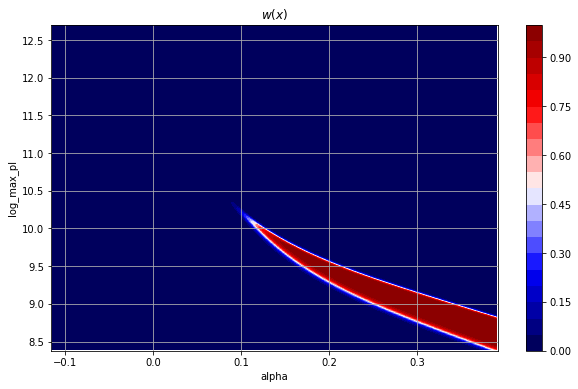

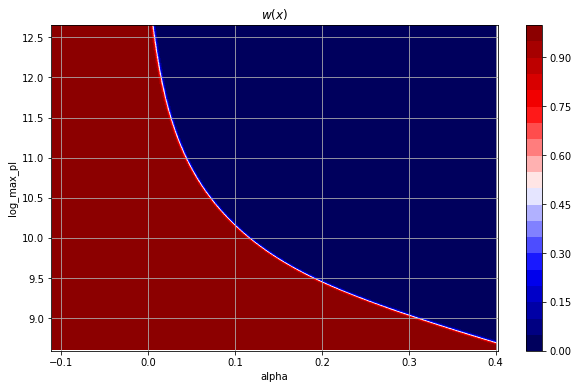

In [57]:
plot_field(w_la.w_model_np(), w_la.dataset(), r'$w(x)$', save='result_la.pdf')
plot_field(w_la3.w_model_np(), w_la3.dataset(), r'$w(x)$', save='result_la3.pdf')

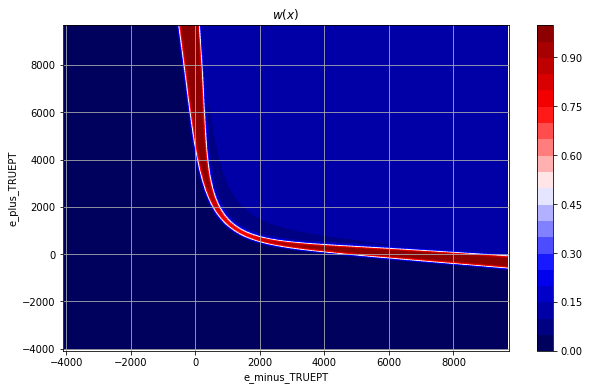

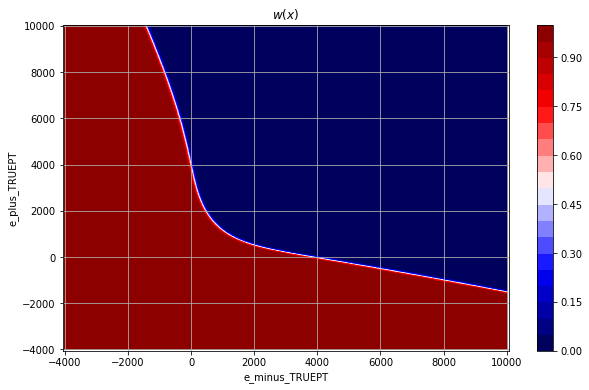

In [58]:
plot_field(w_ptpt.w_model_np(), w_ptpt.dataset(), r'$w(x)$')
plot_field(w_ptpt3.w_model_np(), w_ptpt3.dataset(), r'$w(x)$')

In [59]:
df = df.iloc[0:8,0:3]

In [60]:
for name, w in [("w", w_la), ("w3", w_la3), ("wpt", w_ptpt), ("wpt3", w_ptpt3)]:
    ds = w.dataset()
    for label, idx in ds.mapping.items():
        d = ds.X[ds.Y==label]
        wd = w.w_model_np()(d)
        df.loc[df.index[idx],name] = np.mean(wd)
        df.loc[df.index[idx],"1-"+name] = 1-np.mean(wd)
df

Total       N   N/Total         w       1-w        w3  \
B⁺→K⁺ee           413741   36689  0.088676  0.073683  0.926317  0.433530   
B⁺→K⁺J/ψ(→ee)    2084124  731925  0.351191  0.010834  0.989166  0.000909   
B⁺→K⁺ψ(2S)(→ee)   869415  247181  0.284307  0.010825  0.989175  0.000909   
D⁺→π⁺φ(→ee)       499520  149292  0.298871  0.010673  0.989327       NaN   

                     1-w3       wpt     1-wpt      wpt3    1-wpt3  
B⁺→K⁺ee          0.566470  0.161638  0.838362  0.099419  0.900581  
B⁺→K⁺J/ψ(→ee)    0.999091  0.122812  0.877188  0.011089  0.988911  
B⁺→K⁺ψ(2S)(→ee)  0.999091  0.122815  0.877185  0.011095  0.988905  
D⁺→π⁺φ(→ee)           NaN  0.122879  0.877121       NaN       NaN

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to \mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
r_{J/\psi}&=\frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
.
\end{aligned}$$

In [61]:
def r_K(a): return 1/a[0]
def r_Jpsi(a): return 1/a[1]
def r_psi2S(a): return 1/a[2]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

In [62]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.0678479229922793, 0.9999913945539417)

In [63]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9364629349072866, 1.0000086055201127)

In [64]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.14703528553815406, 1.0007863227333473)

In [65]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(6.801088570950616, 0.9992142950842896)

### Conditional plots

In [66]:
def plot_e(w_obj, feature, bins):
    ds = w_obj.dataset()
    ds_features = ds.features
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = w_obj.w_model_np()
    bins_q2 = np.linspace(0,14e6,101)
    for label, idx in ds.mapping.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label,0]
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        plt.step(bins[:-1], hd, where='post', label=df_index[idx])
    plt.title("e(%s) for %s" % (feature, ds_features))
    plt.legend()
    plt.grid()
    plt.show()

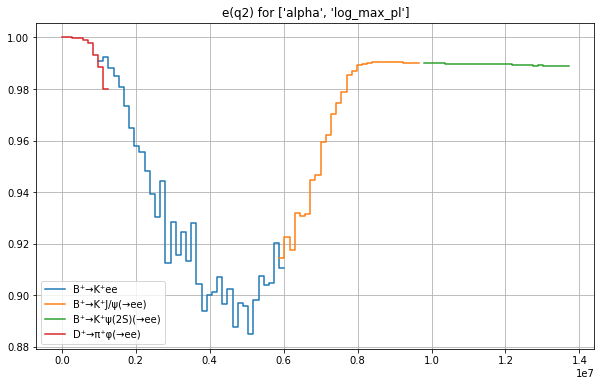

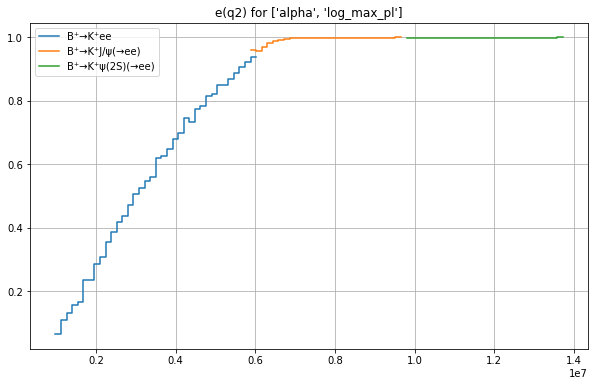

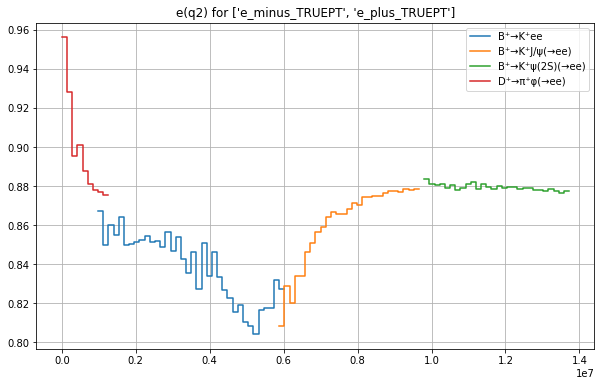

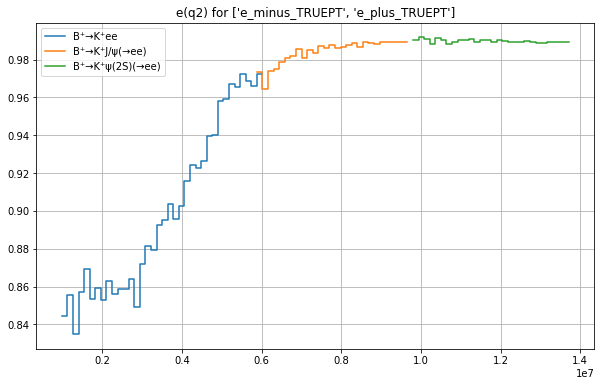

In [67]:
plot_e(w_la, "q2", bins=np.linspace(0,14e6,101))
plot_e(w_la3, "q2", bins=np.linspace(0,14e6,101))
plot_e(w_ptpt, "q2", bins=np.linspace(0,14e6,101))
plot_e(w_ptpt3, "q2", bins=np.linspace(0,14e6,101))

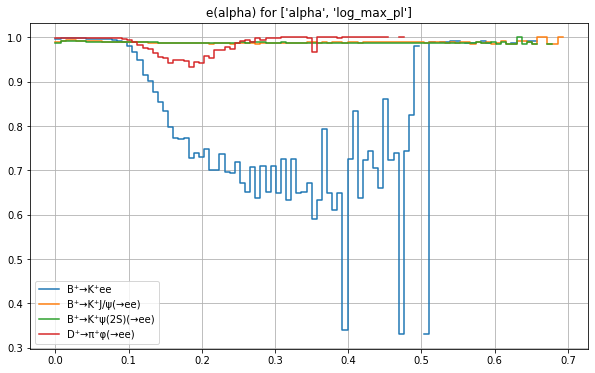

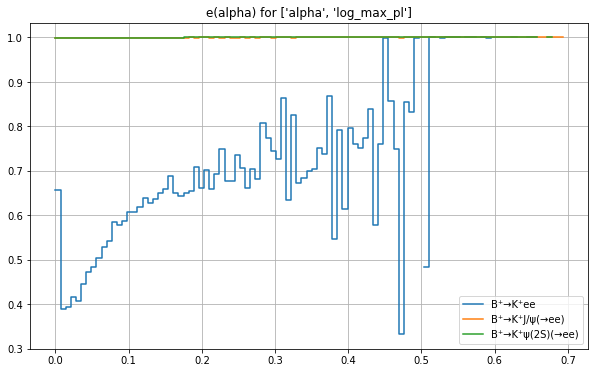

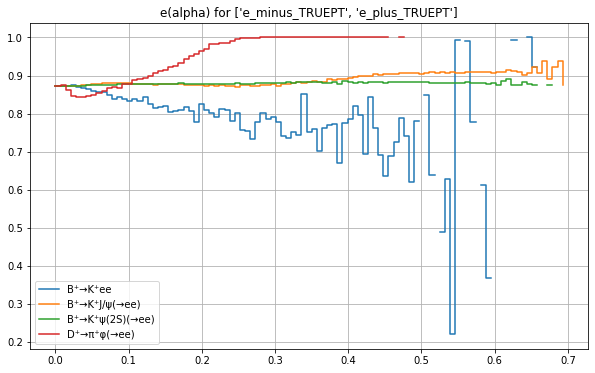

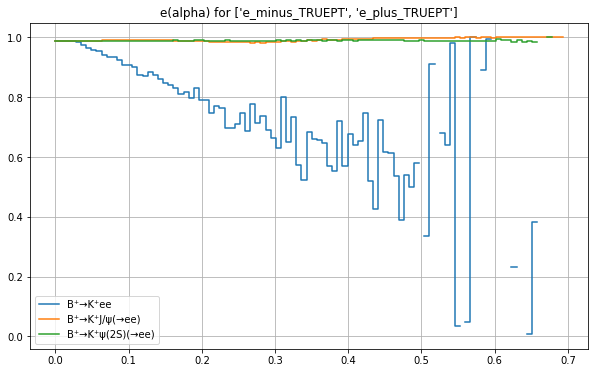

In [68]:
plot_e(w_la, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_la3, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.7,101))

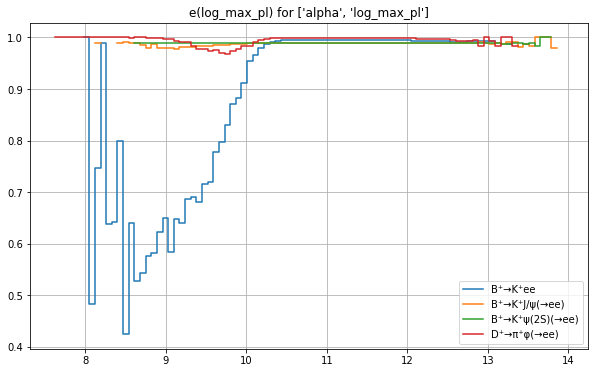

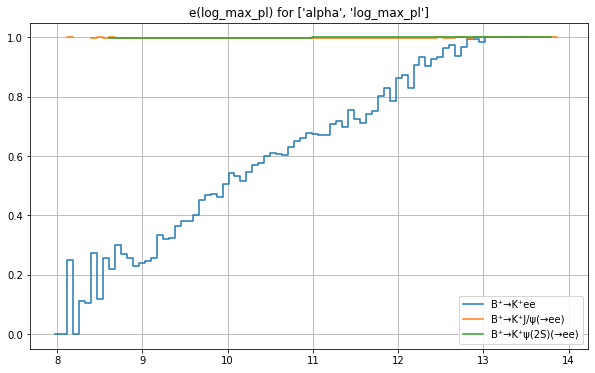

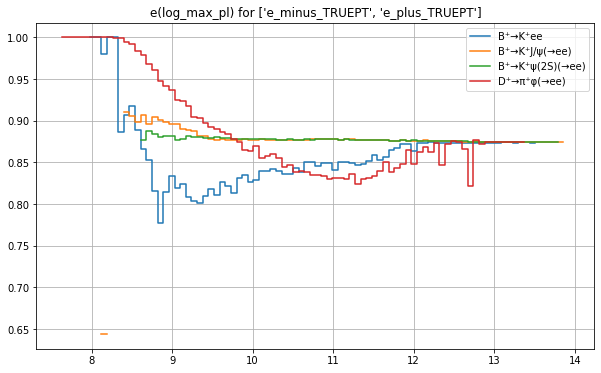

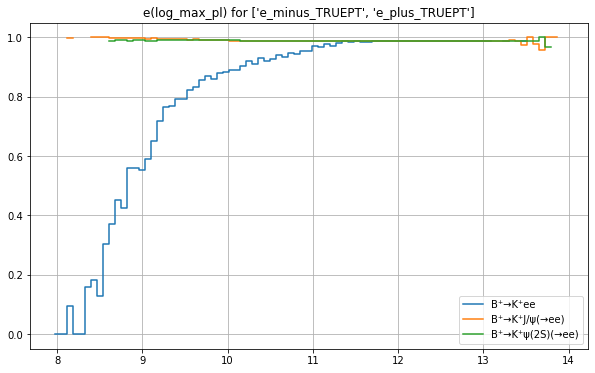

In [69]:
plot_e(w_la, "log_max_pl", bins=np.linspace(7,14,101))
plot_e(w_la3, "log_max_pl", bins=np.linspace(7,14,101))
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(7,14,101))
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(7,14,101))

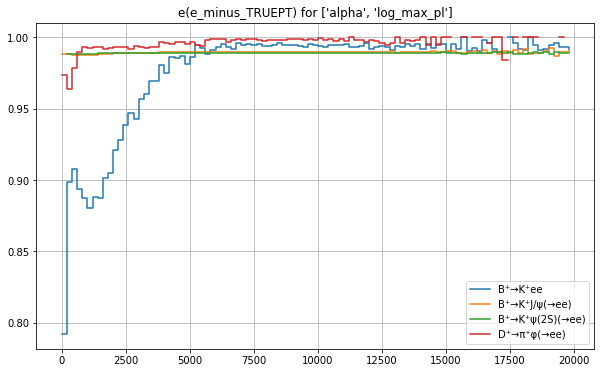

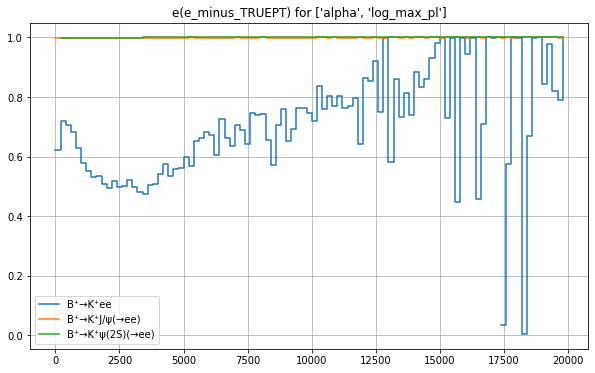

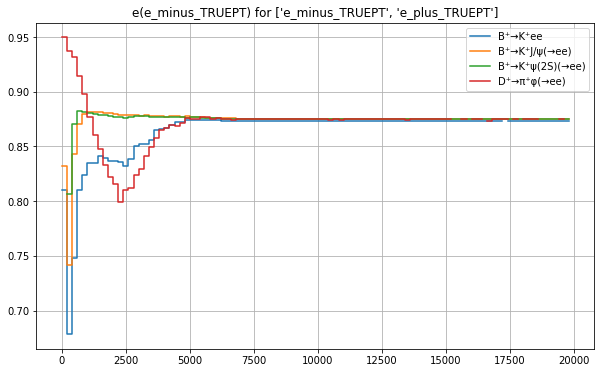

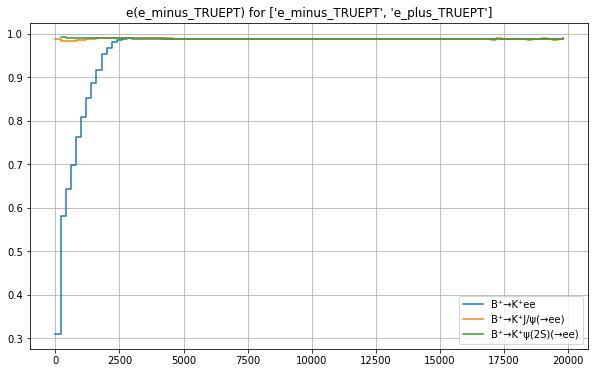

In [70]:
plot_e(w_la, "e_minus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_la3, "e_minus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_ptpt, "e_minus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_ptpt3, "e_minus_TRUEPT", bins=np.linspace(0,20000,101))

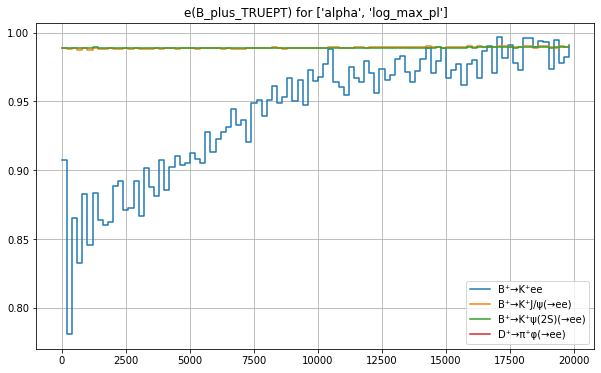

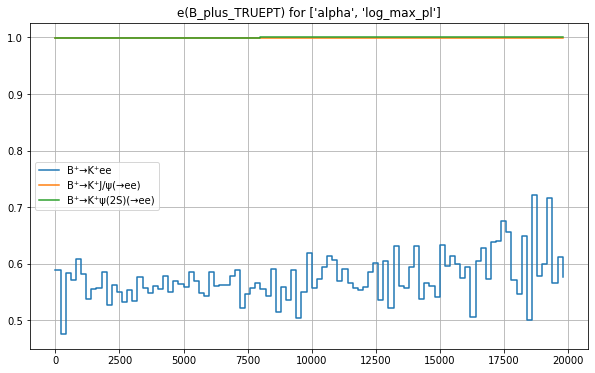

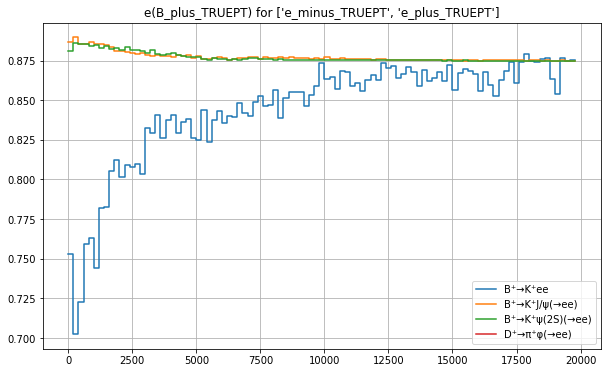

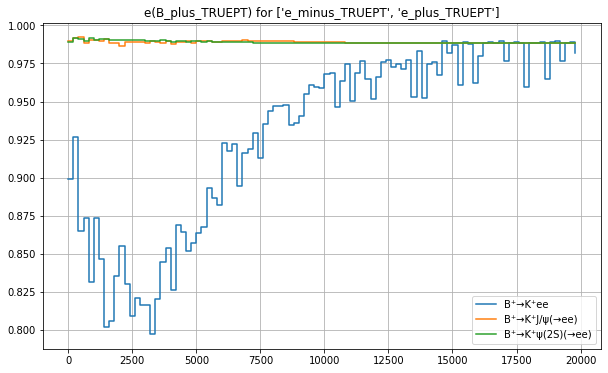

In [71]:
plot_e(w_la, "B_plus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_la3, "B_plus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_ptpt, "B_plus_TRUEPT", bins=np.linspace(0,20000,101))
plot_e(w_ptpt3, "B_plus_TRUEPT", bins=np.linspace(0,20000,101))

### Single feature

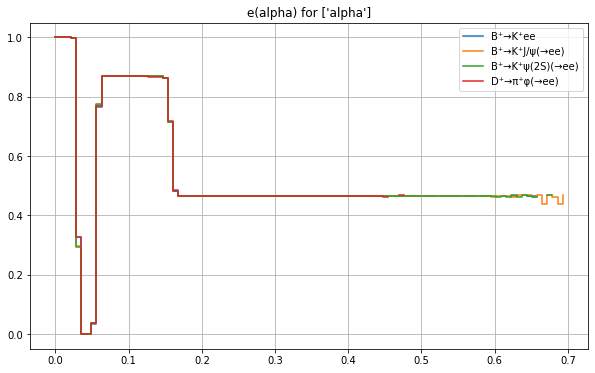

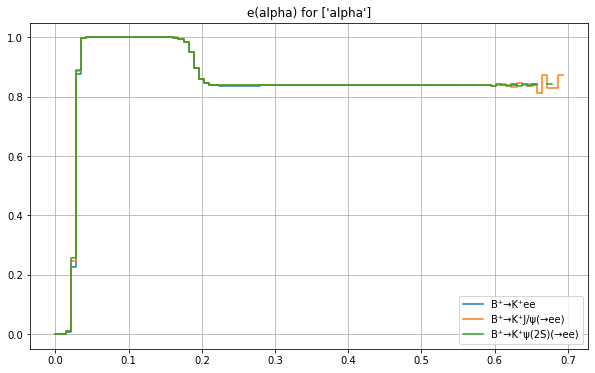

In [72]:
plot_e(w_a4, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_a3, "alpha", bins=np.linspace(0,0.7,101))

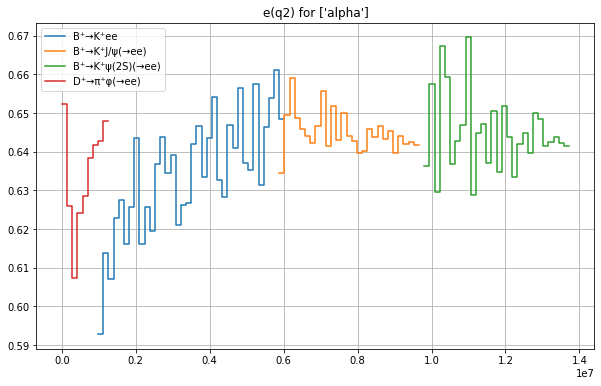

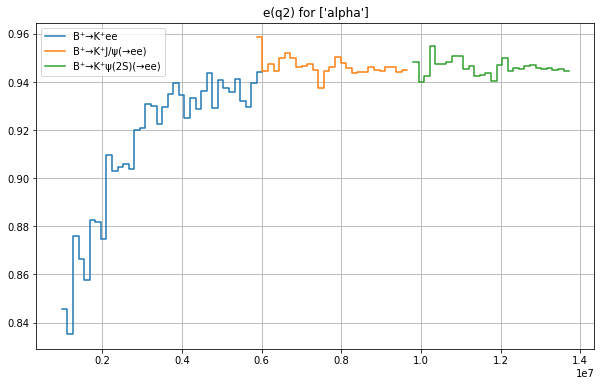

In [73]:
plot_e(w_a4, "q2", bins=np.linspace(0,14e6,101))
plot_e(w_a3, "q2", bins=np.linspace(0,14e6,101))